In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the libraries

%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import xarray as xr
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Droid Sans'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 1.5
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

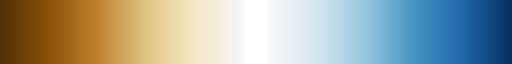

In [4]:
n = 35
diff = 0.5
cmap = plt.cm.BrBG
cmap2 = plt.cm.RdBu
lower = cmap(np.linspace(0, diff, n))
white = np.ones((2, 4))
upper = cmap2(np.linspace(1-diff, 1, n))
colors = np.vstack((lower, white, white, upper))
BrBU = mpl.colors.LinearSegmentedColormap.from_list('map_white', colors)
BrBU

In [5]:
# plotting code
import matplotlib as m
from matplotlib.colors import BoundaryNorm as BM
from matplotlib.colors import Normalize as NN


def plot_background(ax):
    ax.add_feature(cfeature.COASTLINE, alpha=0.9, lw=0.5)
    # ax.add_feature(cfeature.LAND, color='lightgray')
    # ax.add_feature(cfeature.OCEAN, color='lightgray')
    gl = ax.gridlines(draw_labels=True,
                      linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    # gl.left_labels = False
    # gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    # gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    return ax

def plot(x, y, z, titles, cmap, levels, extend='both', cbar_label = 'Precip', pval1 = [], pval2=[], sign_val=0.05, nrows=1, ncols=3, figsize=(12,4), ocean_mask_list = [0], central_longitude=180):
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True, subplot_kw={'projection':ccrs.Robinson(central_longitude=central_longitude)})
    
    axlist = axarr.flatten()
    
    for ax in axlist:
        plot_background(ax)
    
    for i in range(len(z)):
        axlist[i].contourf(x, y, z[i], cmap = cmap, transform = ccrs.PlateCarree(central_longitude=0), levels=levels, extend=extend)
        axlist[i].set_title(titles[i])
        if pval1 != [] and pval2 == []:
            axlist[i].scatter(x[np.abs(pval1[i]) < sign_val], y[np.abs(pval1[i]) < sign_val], color = 'k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
        if pval2 != [] and pval1 == []:
            axlist[i].scatter(x[(pval2[i]) == sign_val], y[(pval2[i]) == sign_val], color = 'k', facecolor='k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
        if i in ocean_mask_list:
            axlist[i].add_feature(cfeature.OCEAN, color = 'lightgray', zorder=1)
        # axlist[i].set_title('IMD', fontdict={'fontsize':12})
        
    norm = BM(levels, 256, extend=extend)
    fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap=cmap), ax = axlist, \
                orientation = 'horizontal', shrink=0.4, aspect = 20, pad = 0.05, label = cbar_label)
    

def plot_mesh(x, y, z, titles, vmin, vmax, cmap, extend='both', cbar_label = 'Precip', pval1 = [], pval2=[], sign_val=0.05, nrows=1, ncols=3, figsize=(12,4), ocean_mask_list = [0], central_longitude=180):
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True, subplot_kw={'projection':ccrs.Robinson(central_longitude=central_longitude)})
    
    axlist = axarr.flatten()
    
    for ax in axlist:
        plot_background(ax)
    
    for i in range(len(z)):
        axlist[i].pcolormesh(x, y, z[i], cmap = cmap, transform = ccrs.PlateCarree(central_longitude=0), vmin=vmin, vmax=vmax)
        axlist[i].set_title(titles[i])
        if pval1 != [] and pval2 == []:
            axlist[i].scatter(x[np.abs(pval1[i]) < sign_val], y[np.abs(pval1[i]) < sign_val], color = 'k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
        if pval2 != [] and pval1 == []:
            axlist[i].scatter(x[(pval2[i]) == sign_val], y[(pval2[i]) == sign_val], color = 'k', facecolor='k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
        if i in ocean_mask_list:
            axlist[i].add_feature(cfeature.OCEAN, color = 'lightgray', zorder=1)
        # axlist[i].set_title('IMD', fontdict={'fontsize':12})
        
    norm = NN(vmin=vmin, vmax=vmax)
    fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap=cmap), ax = axlist, extend=extend, \
                orientation = 'horizontal', shrink=0.4, aspect = 20, pad = 0.05, label = cbar_label)

## importing data

In [9]:
precip = xr.open_dataset('/scratch/ob22/as8561/data/preproc/obs/precip.nc').precip
precip = precip.assign_coords({"lon": (((precip.lon + 180) % 360) - 178.5)})
precip = precip.sortby(precip.lon)
nino = xr.open_dataset('/scratch/ob22/as8561/data/preproc/rean/nino.nc').nino

In [10]:
precip_base = xr.open_dataset('/scratch/ob22/as8561/data/preproc/obs/base_precip.nc').precip
precip_base = precip_base.assign_coords({"lon": (((precip_base.lon + 180) % 360) - 178.5)})
precip_base = precip_base.sortby(precip_base.lon)

In [11]:
weights = np.cos(np.deg2rad(precip.lat))
weights.name = 'weights'

## extracting values

In [12]:
import pandas as pd
from dateutil.relativedelta import relativedelta

In [13]:
import climtas

In [14]:
threshold = float(nino.std())
threshold

0.7658736705780029

In [15]:
# nino_events = climtas.event.find_events(nino.rolling(time=5).mean('time') > threshold, min_duration=6)
# nino_events

In [16]:
# nina_events = climtas.event.find_events(nino.rolling(time=5).mean('time') < -threshold, min_duration=6)
# nina_events

In [17]:
from scipy import stats

In [22]:
def find_indices(nino_events, nina_events):
    nino_idx = []
    nina_idx = []
    for i in range(len(nino_events)):
        start_en = nino_events['time'].to_numpy()[i]
        end_en = nino_events['event_duration'].to_numpy()[i]
        for j in range(end_en):
            nino_idx.append(start_en+j)
    for i in range(len(nina_events)):
        start_ln = nina_events['time'].to_numpy()[i]
        end_ln = nina_events['event_duration'].to_numpy()[i]
        for j in range(end_ln):
            nina_idx.append(start_ln+j)
    return nino_idx, nina_idx

###

def get_event_indices(nino_anom, threshold, min_duration, rolling_period):
    # import climtas
    nino_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') > threshold, min_duration=min_duration)
    nina_events = climtas.event.find_events(nino_anom.rolling(time=rolling_period).mean('time') < -threshold, min_duration=min_duration)
    nino_idx, nina_idx = find_indices(nino_events, nina_events)
    enso_idx = np.sort(np.concatenate((nino_idx, nina_idx)))
    total = np.arange(0, len(nino_anom))
    neut_idx = np.delete(total, enso_idx)
    return nino_idx, nina_idx, neut_idx

###

# functions to calculate correlation value
def get_corr_1d(x, y):
    statistic, _ = stats.spearmanr(x, y)
    return statistic


def get_pval_1d(x, y):
    _, pval = stats.spearmanr(x, y)
    return pval


def get_corr(x, y, dim):
    return xr.apply_ufunc(get_corr_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')


def get_pval(x, y, dim):
    return xr.apply_ufunc(get_pval_1d, x, y, input_core_dims=[[dim], [dim]], vectorize=True, dask = 'parallelized')

####

def reorder(da):
    custom = da.sel(time=da.time.dt.month.isin([6,7,8,9,10,11,12,1,2,3,4,5]))
    # convert cftime to datetime
    datetimeindex = custom.indexes['time']#.to_datetimeindex() 
    custom['time'] = pd.to_datetime(datetimeindex)
    
    # Add custom group by year functionality
    custom_year = custom['time'].dt.year
    
    # convert time type to pd.Timestamp
    time1 = [pd.Timestamp(i) for i in custom_year['time'].values] 
    
    # Add year to Timestamp objects when month is before Jan. (relativedelta does not work from np.datetime64)
    time2 = [i + relativedelta(years=1) if i.month>=6 else i for i in time1] 
    custom['time'] = time2
    return custom

####


def extract_composites(detrended_var, nino_anom, base_var, season_str=None, threshold=0.8, min_duration=6, rolling_period=5):
    if season_str==None: # for the annual period
        # reorder the vars
        detrended_var = reorder(detrended_var)
        nino_anom = reorder(nino_anom)
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # get the standard devitation of the detrended var
        var_std = detrended_var.groupby('time.year').mean('time').std('year')
        # get the climatology of the base var
        var_clim = base_var.mean('month')
        # get the overall teleconnection
        var_corr = get_corr(nino_anom.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year')
        var_pval = get_pval(nino_anom.groupby('time.year').mean('time'), detrended_var.groupby('time.year').mean('time'), 'year')
        # get the nino_event_months
        neut = (detrended_var[neut_idx].groupby('time.year').mean('time')).median('year')
        nino = (detrended_var[nino_idx].groupby('time.year').mean('time')).median('year')
        nina = (detrended_var[nina_idx].groupby('time.year').mean('time')).median('year')
        # calc nino_change
        enc = (nino-neut)
        lnc = (nina-neut)
        # calc index
        lin = (enc - lnc)/2
        nonl = (enc + lnc)/2
        # index ratio
        ratio = nonl/np.abs(lin)
        # get the contribs
        lin_en = xr.where(np.abs(enc) > np.abs(lnc), (lin/enc), 0)
        nonl_en = xr.where(np.abs(enc) > np.abs(lnc), (nonl/enc), 0)
        nature_en = xr.where(np.abs(enc) - np.abs(lnc) > 1, 1, 0)
        #
        lin_ln = xr.where(np.abs(lnc) > np.abs(enc), (-lin/lnc), 0)
        nonl_ln = xr.where(np.abs(lnc) > np.abs(enc), (nonl/lnc), 0)
        nature_ln = xr.where(np.abs(lnc) - np.abs(enc) > 1, -1, 0)
        #
        lin_pc = lin_en + lin_ln
        nonl_pc = nonl_en + nonl_ln
        nature = nature_en + nature_ln
        # get nature
        # nature_nino = xr.where((np.abs(nino_change) - np.abs(nina_change)) > 0.1, 1, 0)
        # nature_nina = xr.where((np.abs(nina_change) - np.abs(nino_change)) > 0.1, 1, 0)
        # get the pvalue for nino and nina events
        return {
            'std': var_std,
            'clim': var_clim,
            'corr': var_corr,
            'pval': var_pval,
            'neut': neut,
            'nino': nino,
            'nina': nina,
            'enc': enc,
            'lnc': lnc,
            'nonl': nonl.where(np.abs(var_corr) >= 0.1, other=0),
            'lin': lin.where(np.abs(var_corr) >= 0.1, other=0),
            'ratio': ratio.where(np.abs(var_corr) >= 0.1, other=0),
            'lin_pc': lin_pc.where(np.abs(var_corr) >= 0.1, other=0),
            'nonl_pc': nonl_pc.where(np.abs(var_corr) >= 0.1, other=0),
            'nature': nature.where(np.abs(var_corr) >= 0.1, other=np.nan),
        }
    else:
        seasons_dict = {'djf':[12,1,2], 'mam':[3,4,5], 'jja':[6,7,8], 'son':[9,10,11]}
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # define the season arr
        season_month_arr = seasons_dict[season_str]
        # get the season for the individual cases
        season = detrended_var.time.dt.month.isin(season_month_arr)
        nino_season = detrended_var[nino_idx].time.dt.month.isin(season_month_arr)
        nina_season = detrended_var[nina_idx].time.dt.month.isin(season_month_arr)
        neut_season = detrended_var[neut_idx].time.dt.month.isin(season_month_arr)
        # get the std of detrended var for that season
        var_std = detrended_var.sel(time=season).groupby('time.year').mean('time').std('year')
        # get the climatology of the base var
        var_clim = base_var.sel(month = season_month_arr).mean('month')
        # get the overall teleconnection
        var_corr = get_corr(nino_anom.sel(time=season).groupby('time.year').mean('time'), detrended_var.sel(time=season).groupby('time.year').mean('time'), 'year')
        var_pval = get_pval(nino_anom.sel(time=season).groupby('time.year').mean('time'), detrended_var.sel(time=season).groupby('time.year').mean('time'), 'year')
        # get the nino_event_months
        neut = (detrended_var[neut_idx].sel(time=neut_season).groupby('time.year').mean('time')).median('year') 
        nino = (detrended_var[nino_idx].sel(time=nino_season).groupby('time.year').mean('time')).median('year')
        nina = (detrended_var[nina_idx].sel(time=nina_season).groupby('time.year').mean('time')).median('year')
        # calc nino_change
        enc = (nino-neut)
        lnc = (nina-neut)
        # calc index
        nonl = (enc + lnc)/2
        lin = (enc - lnc)/2
        # index ratio
        ratio = nonl/np.abs(lin)
        # get the contribs
        lin_en = xr.where(np.abs(enc) > np.abs(lnc), (lin/enc), 0)
        nonl_en = xr.where(np.abs(enc) > np.abs(lnc), (nonl/enc), 0)
        nature_en = xr.where(np.abs(enc) - np.abs(lnc) > 1, 1, 0)
        #
        lin_ln = xr.where(np.abs(lnc) > np.abs(enc), (-lin/lnc), 0)
        nonl_ln = xr.where(np.abs(lnc) > np.abs(enc), (nonl/lnc), 0)
        nature_ln = xr.where(np.abs(lnc) - np.abs(enc) > 1, -1, 0)
        #
        lin_pc = lin_en + lin_ln
        nonl_pc = nonl_en + nonl_ln
        nature = nature_en + nature_ln
        # get nature
        # nature_nino = xr.where((np.abs(nino_change) - np.abs(nina_change)) > 0.1, 1, 0)
        # nature_nina = xr.where((np.abs(nina_change) - np.abs(nino_change)) > 0.1, 1, 0)
        # get the pvalue for nino and nina events for that season
        # season_en = detrended_var[nino_anom > 0].time.dt.month.isin(season_month_arr)
        # season_ln = detrended_var[nino_anom < 0].time.dt.month.isin(season_month_arr)
        # pvalue = spearman_corr3d(nino_anom.expand_dims(dim={'lat':61, 'lon':121}).sel(time=season).groupby('time.year').mean('time').chunk(dict(year=-1)), detrended_var.sel(time=season).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        # pvalue_nina = spearman_corr3d(nino_anom[nino_anom < 0].expand_dims(dim={'lat':61, 'lon':121}).sel(time=season_ln).groupby('time.year').mean('time').chunk(dict(year=-1)),\
        #                               detrended_var[nino_anom < 0].sel(time=season_ln).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        # pvalue_nino = spearman_corr3d(nino_anom[nino_anom > 0].expand_dims(dim={'lat':61, 'lon':121}).sel(time=season_en).groupby('time.year').mean('time').chunk(dict(year=-1)),\
        #                               detrended_var[nino_anom > 0].sel(time=season_en).groupby('time.year').mean('time').chunk(dict(year=-1)), dim='year')
        return {
            'std': var_std,
            'clim': var_clim,
            'corr': var_corr,
            'pval': var_pval,
            'neut': neut,
            'nino': nino,
            'nina': nina,
            'enc': enc,
            'lnc': lnc,
            'nonl': nonl.where(np.abs(var_corr) >= 0.1, other=0),
            'lin': lin.where(np.abs(var_corr) >= 0.1, other=0),
            'ratio': ratio.where(np.abs(var_corr) >= 0.1, other=0),
            'lin_pc': lin_pc.where(np.abs(var_corr) >= 0.1, other=0),
            'nonl_pc': nonl_pc.where(np.abs(var_corr) >= 0.1, other=0),
            'nature': nature.where(np.abs(var_corr) >= 0.1, other=np.nan),
        }

In [149]:
import regionmask

In [150]:
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask_3D(precip, wrap_lon=False)

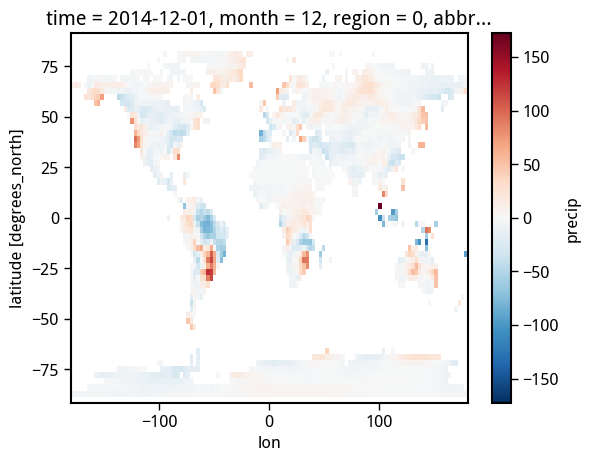

In [151]:
precip.where(mask.isel(region=0))[-1].plot()

In [152]:
res_djf = extract_composites(precip, nino, precip_base, season_str='djf', threshold=threshold, min_duration=6, rolling_period=5)
res_mam = extract_composites(precip, nino, precip_base, season_str='mam', threshold=threshold, min_duration=6, rolling_period=5)
res_jja = extract_composites(precip, nino, precip_base, season_str='jja', threshold=threshold, min_duration=6, rolling_period=5)
res_son = extract_composites(precip, nino, precip_base, season_str='son', threshold=threshold, min_duration=6, rolling_period=5)

In [153]:
res_ann = extract_composites(precip, nino, precip_base, season_str=None, threshold=threshold, min_duration=6, rolling_period=5)

#### Plotting the std and corr for different ANN and different Seasons

In [129]:
def fix_gap_lon(arr, lons):
    new_arr = []
    for val in arr:
        out, xx = add_cyclic_point(val, lons)
        new_arr.append(out)
    return new_arr, xx

In [130]:
std_list = [res_ann['std'], res_djf['std'], res_mam['std'], res_jja['std'], res_son['std']]

In [131]:
std_list, xx = fix_gap_lon(std_list, np.arange(-178.5, 184.5, 3))

In [132]:
titles_list = ['ANN', 'DJF', 'MAM', 'JJA', 'SON']

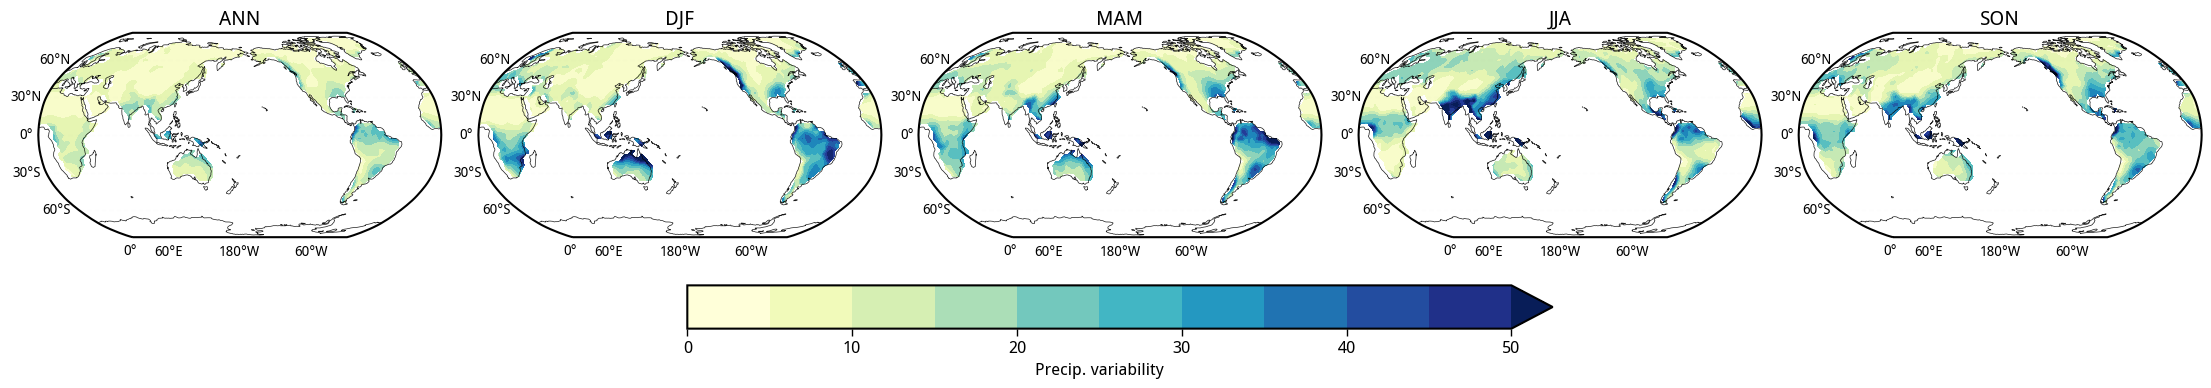

In [133]:
plot_kwargs = dict(cmap='YlGnBu', levels = np.arange(0,55,5), extend='max', cbar_label = 'Precip. variability', \
                   pval1 = [], nrows=1, ncols=5, figsize=(22,6), ocean_mask_list = [], central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot(x, y, std_list, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/precip_std.png', dpi=300, bbox_inches='tight')

In [39]:
corr_list = [res_ann['corr'], res_djf['corr'], res_mam['corr'], res_jja['corr'], res_son['corr']]

In [40]:
corr_list, xx = fix_gap_lon(corr_list, np.arange(-178.5, 184.5, 3))

In [41]:
pval_list = [res_ann['pval'], res_djf['pval'], res_mam['pval'], res_jja['pval'], res_son['pval']]

In [42]:
pval_list, xx = fix_gap_lon(pval_list, np.arange(-178.5, 184.5, 3))

In [43]:
titles_list = ['ANN', 'DJF', 'MAM', 'JJA', 'SON']

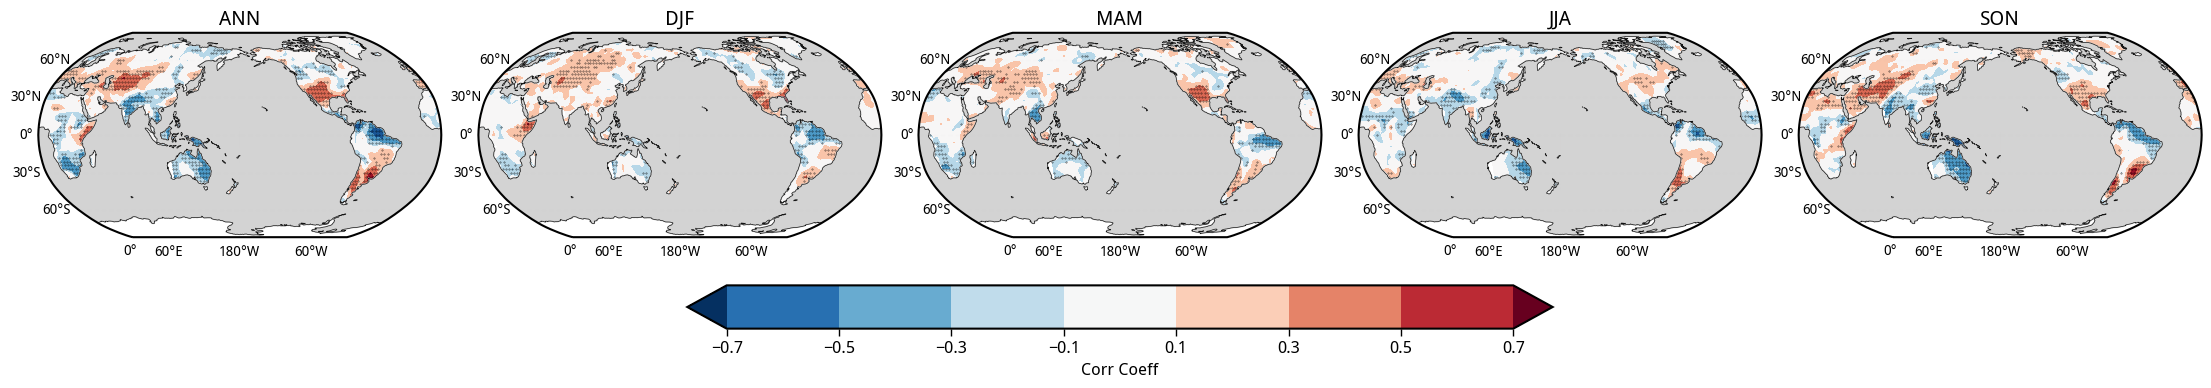

In [44]:
plot_kwargs = dict(cmap='RdBu_r', levels = np.arange(-0.7, 0.9, 0.2), extend='both', cbar_label = 'Corr Coeff', \
                   pval1 = pval_list, nrows=1, ncols=5, figsize=(22,6), ocean_mask_list = [0,1,2,3,4], central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot(x, y, corr_list, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/precip_corr.png', dpi=300, bbox_inches='tight')

In [45]:
clim_list = [res_ann['clim'], res_djf['clim'], res_mam['clim'], res_jja['clim'], res_son['clim']]

In [46]:
clim_list, xx = fix_gap_lon(clim_list, np.arange(-178.5, 184.5, 3))

In [47]:
titles_list = ['ANN', 'DJF', 'MAM', 'JJA', 'SON']

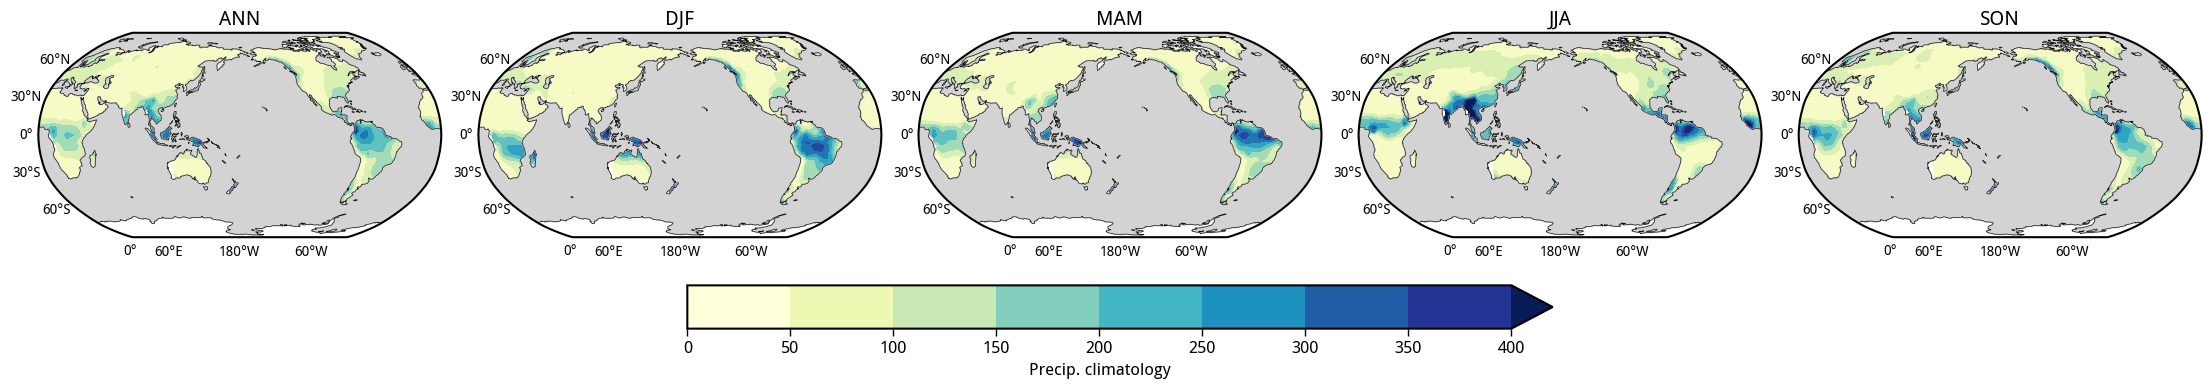

In [123]:
plot_kwargs = dict(cmap='YlGnBu', levels = np.arange(0,450,50), extend='max', cbar_label = 'Precip. climatology', \
                   pval1 = [], nrows=1, ncols=5, figsize=(22,6), ocean_mask_list = [0,1,2,3,4], central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot(x, y, clim_list, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/precip_clim.png', dpi=300, bbox_inches='tight')

#### Plotting the results for nonlinearity

In [49]:
# plot_list = [res_ann['neut'].where(np.abs(res_ann['corr']) > 0.1), res_djf['neut'].where(np.abs(res_djf['corr']) > 0.1), res_mam['neut'].where(np.abs(res_mam['corr']) > 0.1), res_jja['neut'].where(np.abs(res_jja['corr']) > 0.1), res_son['neut'].where(np.abs(res_son['corr']) > 0.1),
#              res_ann['nino'].where(np.abs(res_ann['corr']) > 0.1), res_djf['nino'].where(np.abs(res_djf['corr']) > 0.1), res_mam['nino'].where(np.abs(res_mam['corr']) > 0.1), res_jja['nino'].where(np.abs(res_jja['corr']) > 0.1), res_son['nino'].where(np.abs(res_son['corr']) > 0.1),
#              res_ann['nina'].where(np.abs(res_ann['corr']) > 0.1), res_djf['nina'].where(np.abs(res_djf['corr']) > 0.1), res_mam['nina'].where(np.abs(res_mam['corr']) > 0.1), res_jja['nina'].where(np.abs(res_jja['corr']) > 0.1), res_son['nina'].where(np.abs(res_son['corr']) > 0.1)]

In [50]:
plot_list = [res_ann['neut'], res_djf['neut'], res_mam['neut'], res_jja['neut'], res_son['neut'],
             res_ann['nino'], res_djf['nino'], res_mam['nino'], res_jja['nino'], res_son['nino'],
             res_ann['nina'], res_djf['nina'], res_mam['nina'], res_jja['nina'], res_son['nina']]

In [51]:
plot_list, xx = fix_gap_lon(plot_list, np.arange(-178.5, 184.5, 3))

In [52]:
# enso_list = (plot_list*np.repeat(np.array(std_list)[np.newaxis, :,:,:], 3, axis=0).reshape(15,61,122))

In [53]:
enso_list_pc = (plot_list/np.repeat(np.array(clim_list)[np.newaxis,:,:,:], 3, axis=0).reshape(15,61,122))*100

In [54]:
titles_list = ['ANN NEUT', 'DJF NEUT', 'MAM NEUT', 'JJA NEUT', 'SON NEUT',
               'ANN NINO', 'DJF NINO', 'MAM NINO', 'JJA NINO', 'SON NINO',
               'ANN NINA', 'DJF NINA', 'MAM NINA', 'JJA NINA', 'SON NINA']

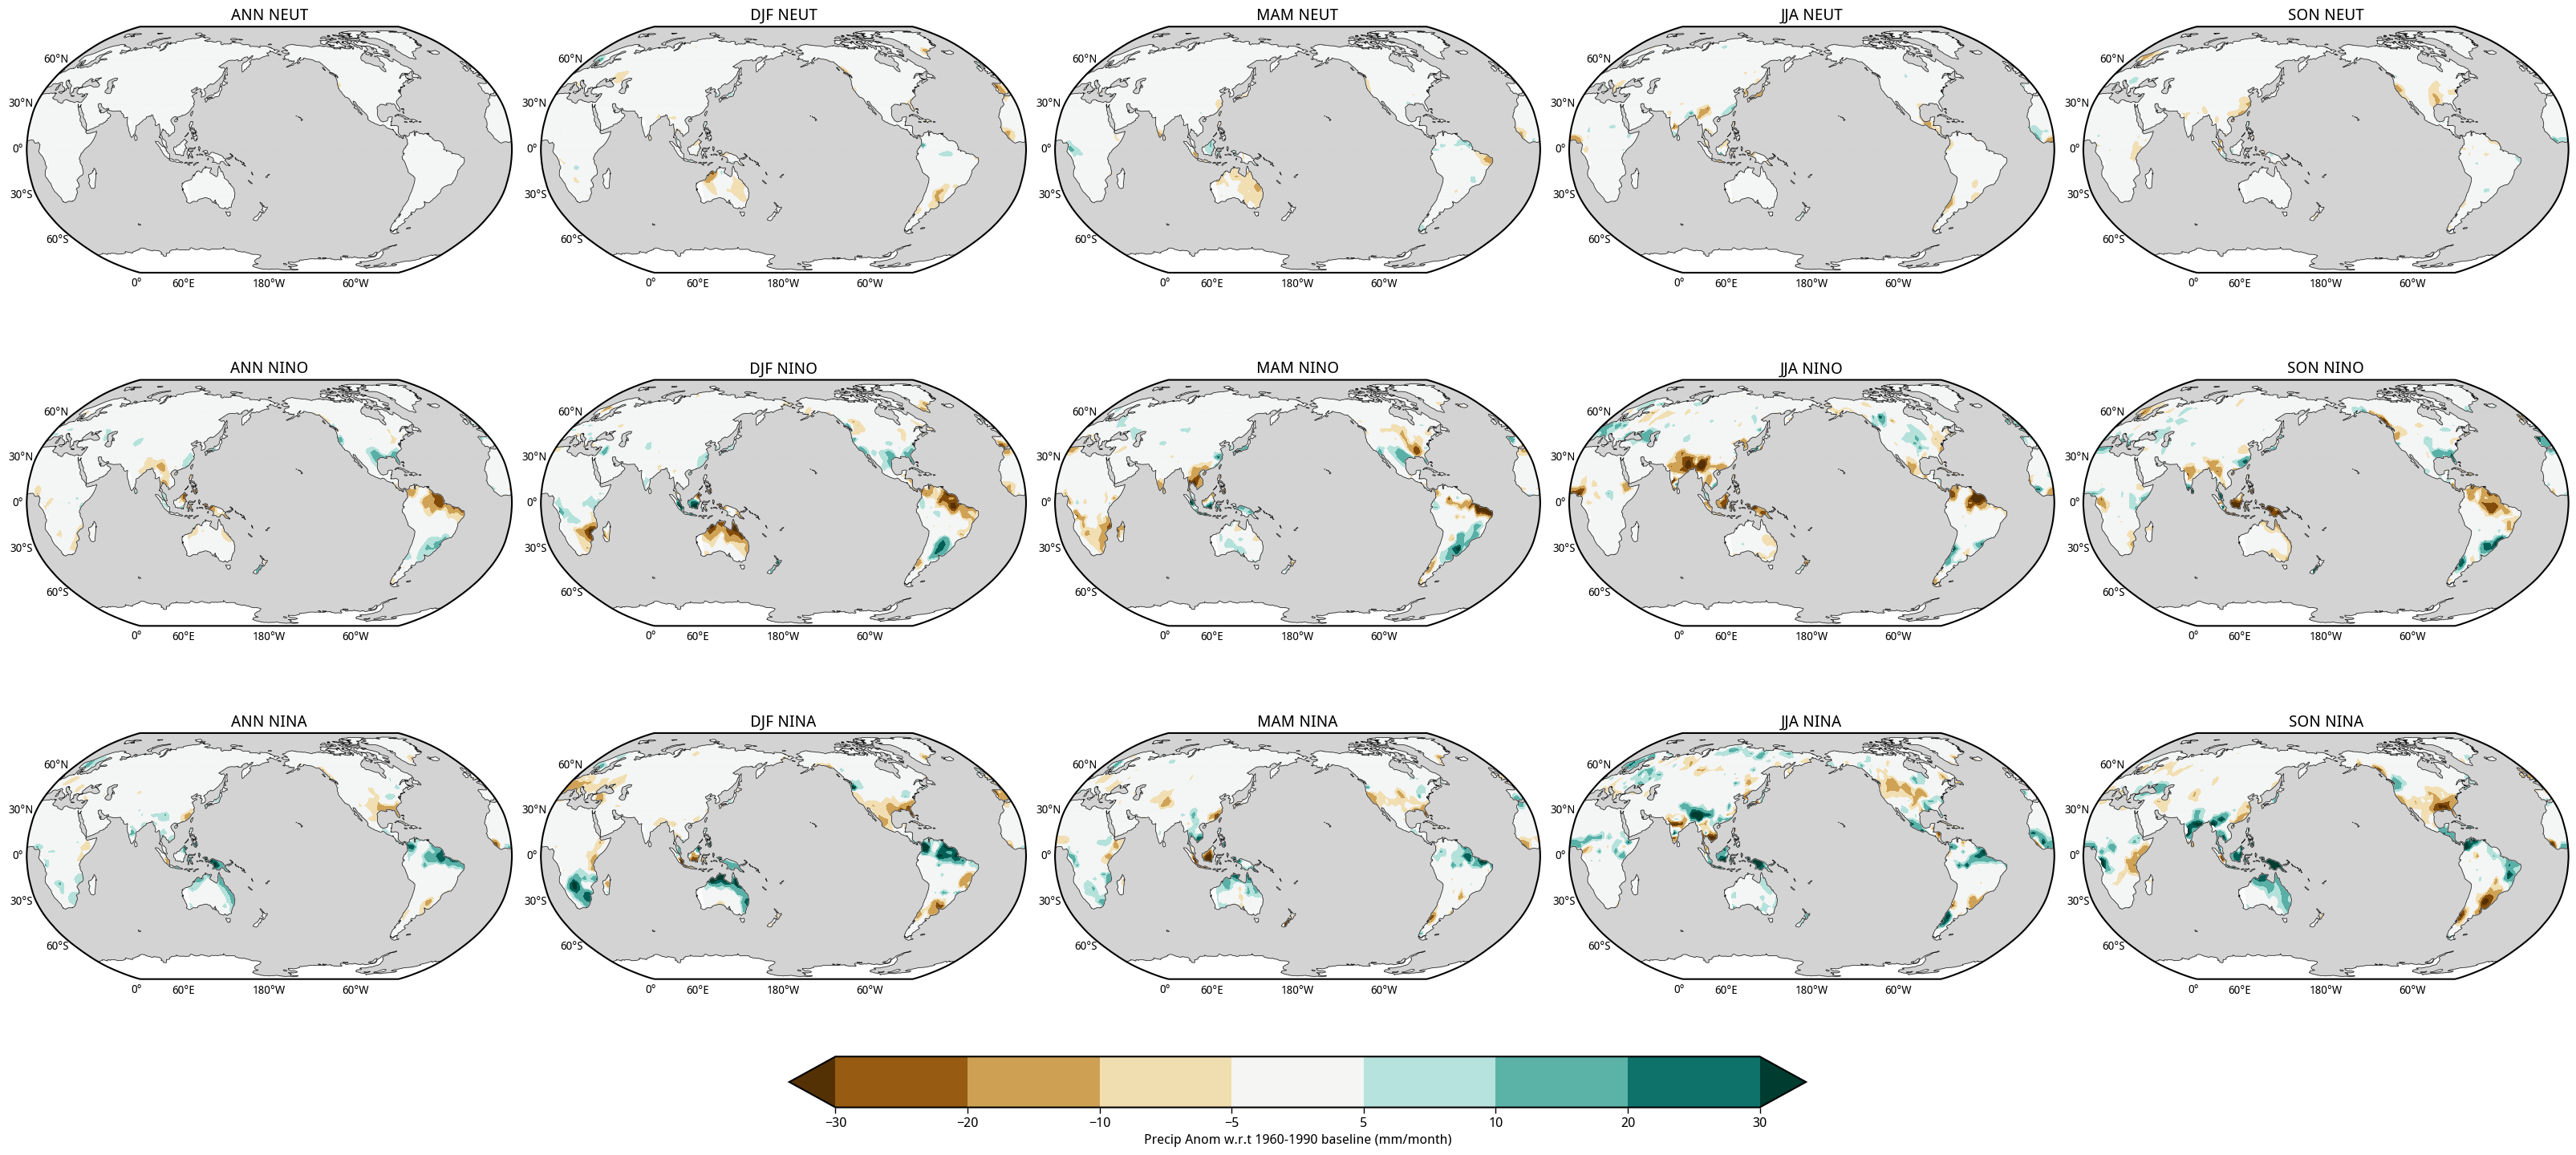

In [55]:
plot_kwargs = dict(cmap='BrBG', levels = [-30, -20, -10, -5, 5, 10, 20, 30], \
                   extend='both', cbar_label = 'Precip Anom w.r.t 1960-1990 baseline (mm/month)', pval1 = [], nrows=3, ncols=5, \
                   figsize=(32,15), ocean_mask_list = np.arange(0,15,1), central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot(x, y, plot_list, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/obs_enso_situtation.png', dpi=300, bbox_inches='tight')

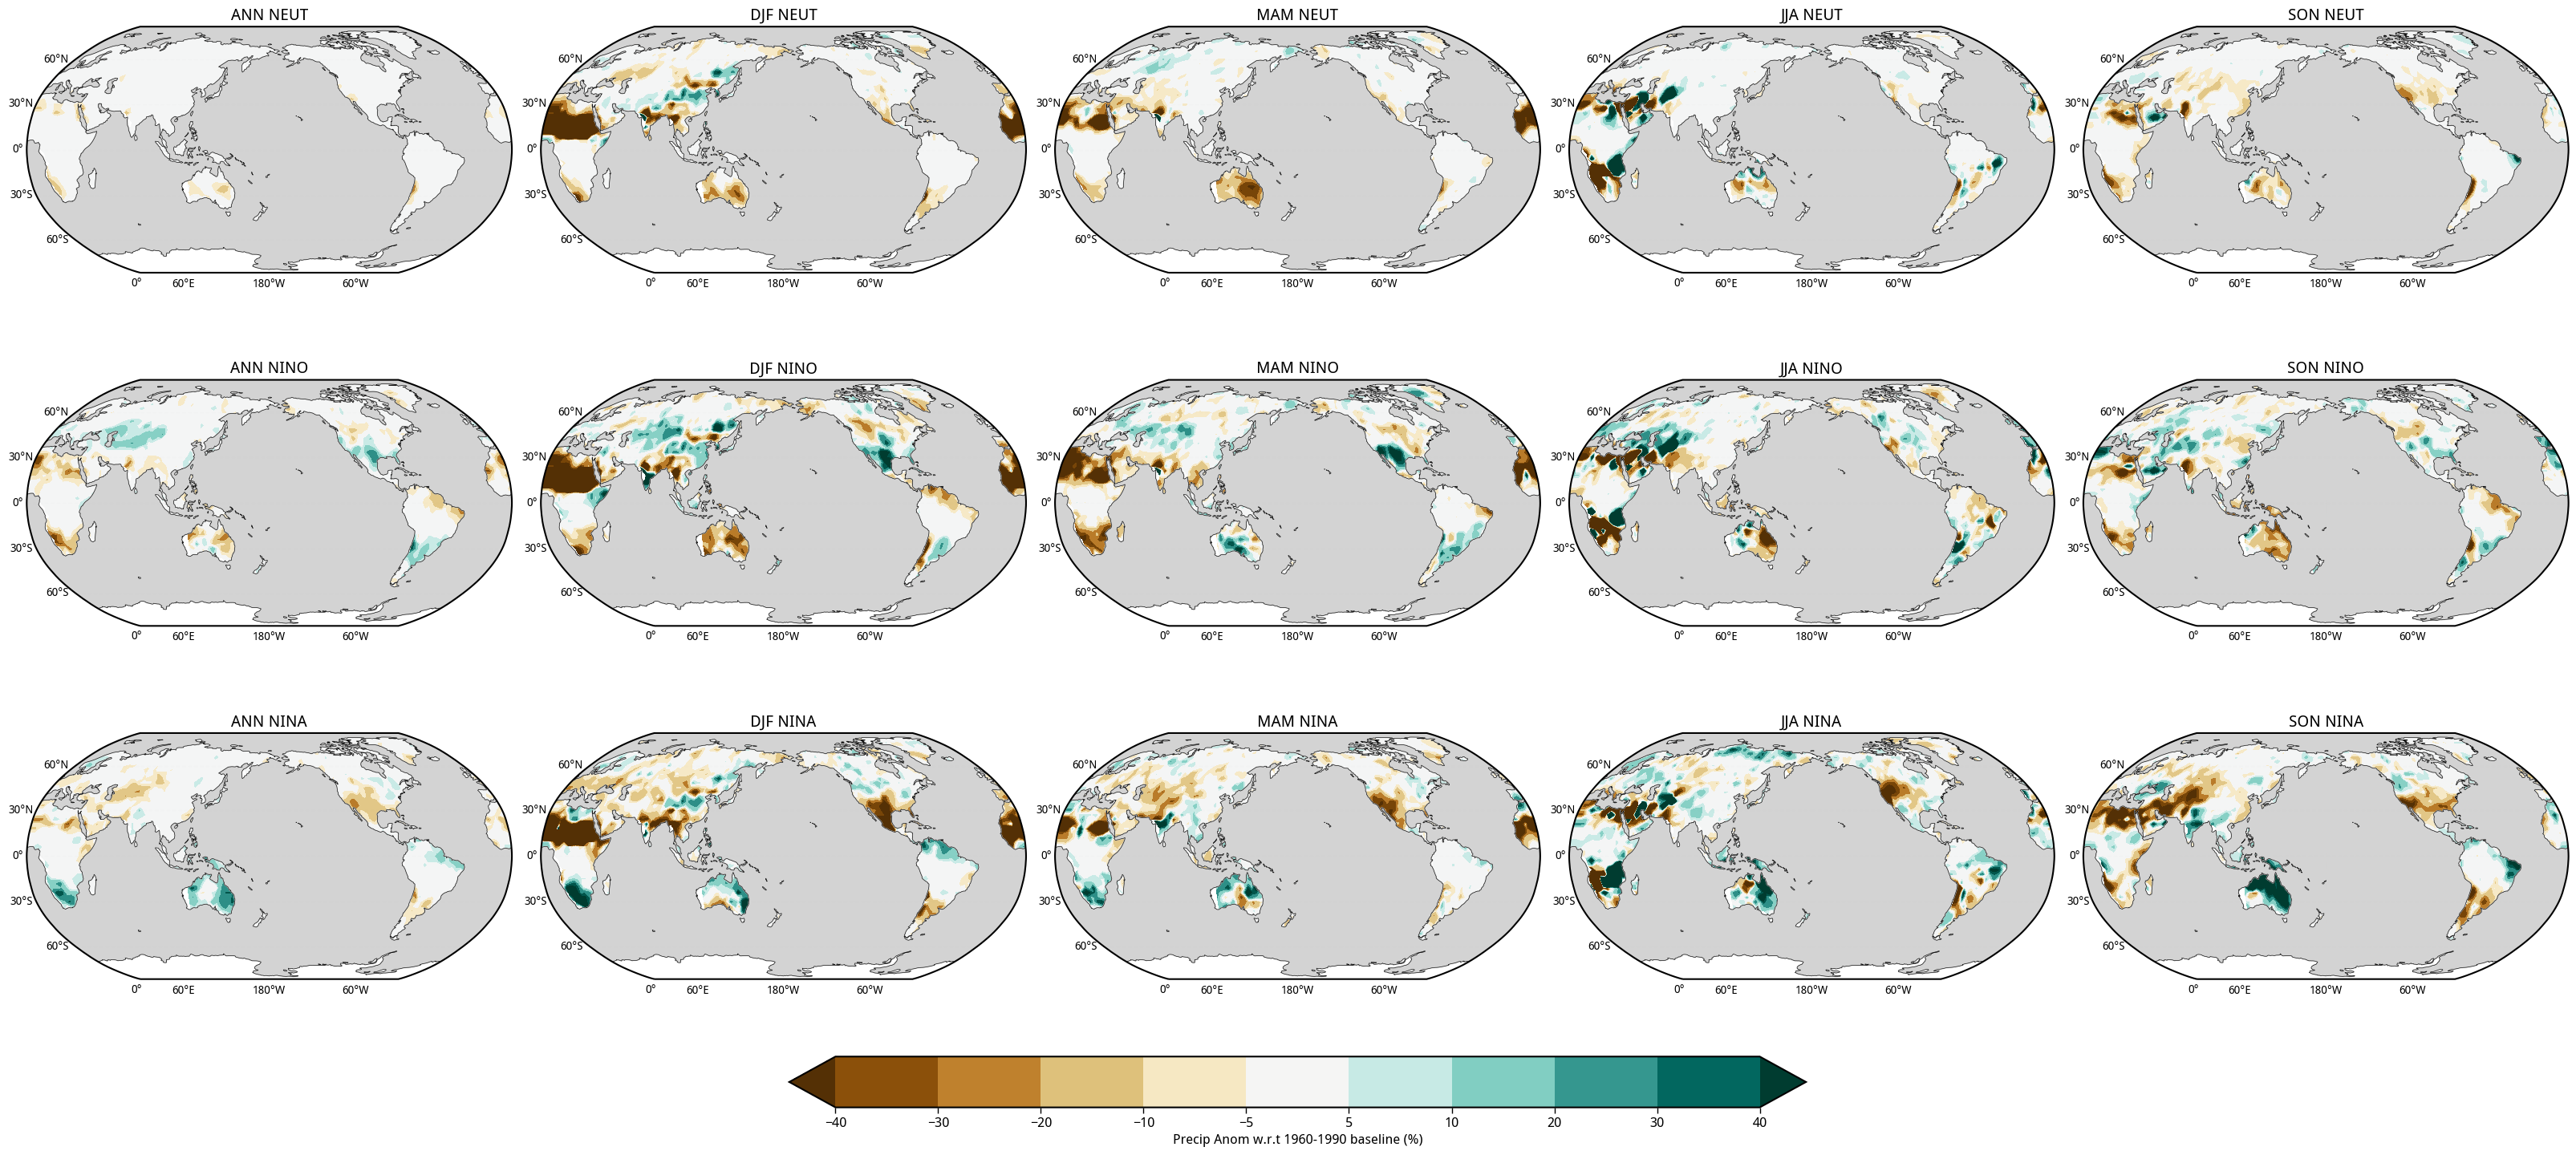

In [56]:
plot_kwargs = dict(cmap='BrBG', levels = [-40, -30, -20, -10, -5, 5, 10, 20, 30, 40], \
                   extend='both', cbar_label = 'Precip Anom w.r.t 1960-1990 baseline (%)', pval1 = [], nrows=3, ncols=5, \
                   figsize=(32,15), ocean_mask_list = np.arange(0,15,1), central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot(x, y, enso_list_pc, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/obs_enso_situtation_pc.png', dpi=300, bbox_inches='tight')

In [57]:
# plot_list = [res_ann['nonlinearity'].where(np.abs(res_ann['corr']) >= 0.1), res_djf['nonlinearity'].where(np.abs(res_djf['corr']) >= 0.1), res_mam['nonlinearity'].where(np.abs(res_mam['corr']) >= 0.1), res_jja['nonlinearity'].where(np.abs(res_jja['corr']) >= 0.1), res_son['nonlinearity'].where(np.abs(res_son['corr']) >= 0.1)]
             # res_ann['linearity'].where(np.abs(res_ann['corr']) >= 0.1), res_djf['linearity'].where(np.abs(res_djf['corr']) >= 0.1), res_mam['linearity'].where(np.abs(res_mam['corr']) >= 0.1), res_jja['linearity'].where(np.abs(res_jja['corr']) >= 0.1)), res_son['linearity'].where(np.abs(res_son['corr']) >= 0.1)]

In [58]:
# nonl_ann = xr.where(np.abs(res_ann['corr']) >= 0.1, res_ann['nonl'], 0)
# nonl_djf = xr.where(np.abs(res_djf['corr']) >= 0.1, res_djf['nonl'], 0)
# nonl_mam = xr.where(np.abs(res_mam['corr']) >= 0.1, res_mam['nonl'], 0)
# nonl_jja = xr.where(np.abs(res_jja['corr']) >= 0.1, res_jja['nonl'], 0)
# nonl_son = xr.where(np.abs(res_son['corr']) >= 0.1, res_son['nonl'], 0)

# lin_ann = xr.where(np.abs(res_ann['corr']) >= 0.1, res_ann['lin'], 0)
# lin_djf = xr.where(np.abs(res_djf['corr']) >= 0.1, res_djf['lin'], 0)
# lin_mam = xr.where(np.abs(res_mam['corr']) >= 0.1, res_mam['lin'], 0)
# lin_jja = xr.where(np.abs(res_jja['corr']) >= 0.1, res_jja['lin'], 0)
# lin_son = xr.where(np.abs(res_son['corr']) >= 0.1, res_son['lin'], 0)

# nonl_pc_ann = xr.where(np.abs(res_ann['corr']) >= 0.1, res_ann['nonl_pc'], 0)
# nonl_pc_djf = xr.where(np.abs(res_djf['corr']) >= 0.1, res_djf['nonl_pc'], 0)
# nonl_pc_mam = xr.where(np.abs(res_mam['corr']) >= 0.1, res_mam['nonl_pc'], 0)
# nonl_pc_jja = xr.where(np.abs(res_jja['corr']) >= 0.1, res_jja['nonl_pc'], 0)
# nonl_pc_son = xr.where(np.abs(res_son['corr']) >= 0.1, res_son['nonl_pc'], 0)

# lin_pc_ann = xr.where(np.abs(res_ann['corr']) >= 0.1, res_ann['lin_pc'], 0)
# lin_pc_djf = xr.where(np.abs(res_djf['corr']) >= 0.1, res_djf['lin_pc'], 0)
# lin_pc_mam = xr.where(np.abs(res_mam['corr']) >= 0.1, res_mam['lin_pc'], 0)
# lin_pc_jja = xr.where(np.abs(res_jja['corr']) >= 0.1, res_jja['lin_pc'], 0)
# lin_pc_son = xr.where(np.abs(res_son['corr']) >= 0.1, res_son['lin_pc'], 0)

# nature_ann = xr.where(np.abs(res_ann['corr']) >= 0.1, res_ann['nature'], np.nan)
# nature_djf = xr.where(np.abs(res_djf['corr']) >= 0.1, res_djf['nature'], np.nan)
# nature_mam = xr.where(np.abs(res_mam['corr']) >= 0.1, res_mam['nature'], np.nan)
# nature_jja = xr.where(np.abs(res_jja['corr']) >= 0.1, res_jja['nature'], np.nan)
# nature_son = xr.where(np.abs(res_son['corr']) >= 0.1, res_son['nature'], np.nan)

# ratio_ann = xr.where(np.abs(res_ann['corr']) >= 0.1, res_ann['ratio'], 0)
# ratio_djf = xr.where(np.abs(res_djf['corr']) >= 0.1, res_djf['ratio'], 0)
# ratio_mam = xr.where(np.abs(res_mam['corr']) >= 0.1, res_mam['ratio'], 0)
# ratio_jja = xr.where(np.abs(res_jja['corr']) >= 0.1, res_jja['ratio'], 0)
# ratio_son = xr.where(np.abs(res_son['corr']) >= 0.1, res_son['ratio'], 0)

# # nonl_ann = res_ann['nonl']
# # nonl_djf = res_djf['nonl']
# # nonl_mam = res_mam['nonl']
# # nonl_jja = res_jja['nonl']
# # nonl_son = res_son['nonl']



In [59]:
plot_list = [res_ann['nonl'], res_djf['nonl'], res_mam['nonl'], res_jja['nonl'], res_son['nonl'],
             res_ann['lin'], res_djf['lin'], res_mam['lin'], res_jja['lin'], res_son['lin']]
# plot_list = [ratio_ann, ratio_djf, ratio_mam, ratio_jja, ratio_son]

In [60]:
plot_list, xx = fix_gap_lon(plot_list, np.arange(-178.5, 184.5, 3))

In [61]:
# index_list = (plot_list*np.repeat(np.array(std_list)[np.newaxis, :,:,:], 1, axis=0).reshape(5,61,122))

In [62]:
index_list_pc = (plot_list/np.repeat(np.array(clim_list)[np.newaxis,:,:,:], 2, axis=0).reshape(10,61,122))*100

In [63]:
titles_list = ['ANN ASYMM', 'DJF ASYMM', 'MAM ASYMM', 'JJA ASYMM', 'SON ASYMM',
               'ANN SYMM', 'DJF SYMM', 'MAM SYMM', 'JJA SYMM', 'SON SYMM']

In [64]:
pval_list = [res_ann['nature'], res_djf['nature'], res_mam['nature'], res_jja['nature'], res_son['nature'],
             res_ann['nature'], res_djf['nature'], res_mam['nature'], res_jja['nature'], res_son['nature']]

In [65]:
pval_list, xx = fix_gap_lon(pval_list, np.arange(-178.5, 184.5, 3))

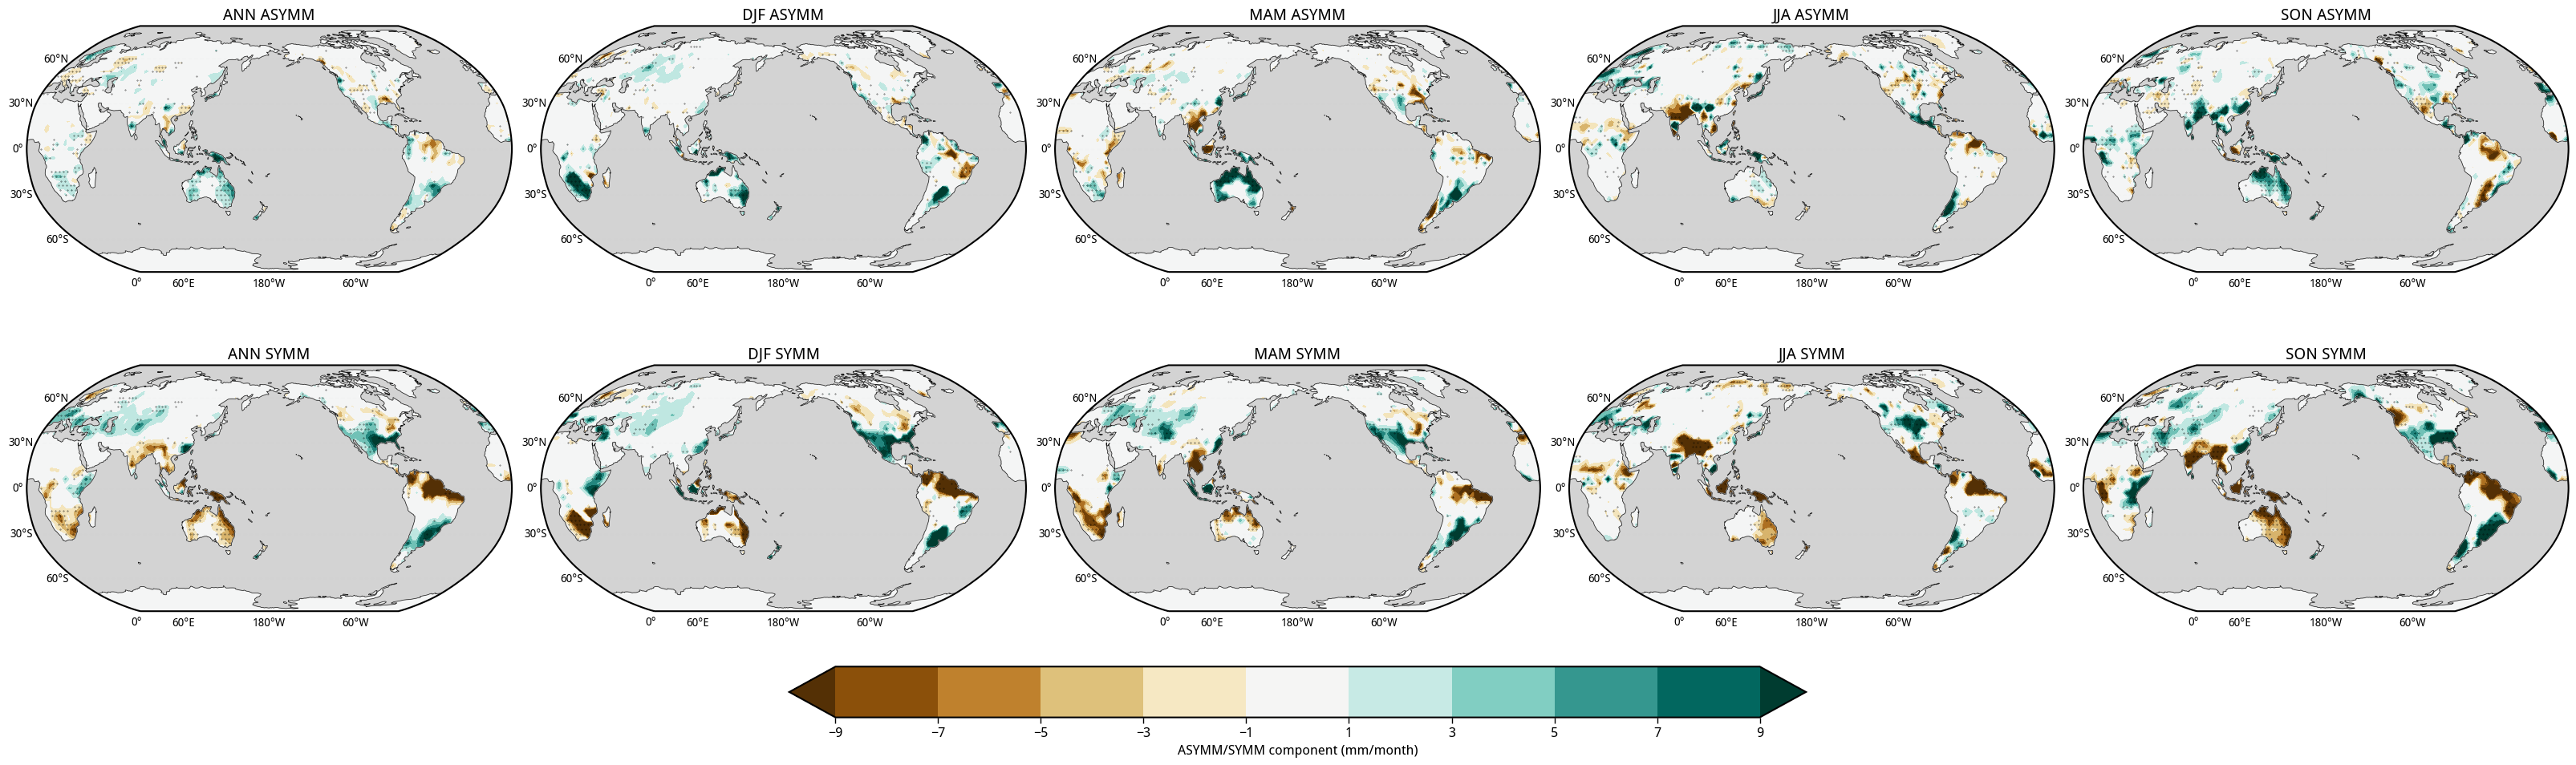

In [66]:
plot_kwargs = dict(cmap='BrBG', levels = np.arange(-9, 11, 2), \
                   extend='both', cbar_label = 'ASYMM/SYMM component (mm/month)', pval1=[], pval2=pval_list, \
                   sign_val=-1, nrows=2, ncols=5, figsize=(32,10), ocean_mask_list = np.arange(0, 15, 1), central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot(x, y, plot_list, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/obs_asymm.png', dpi=300, bbox_inches='tight')

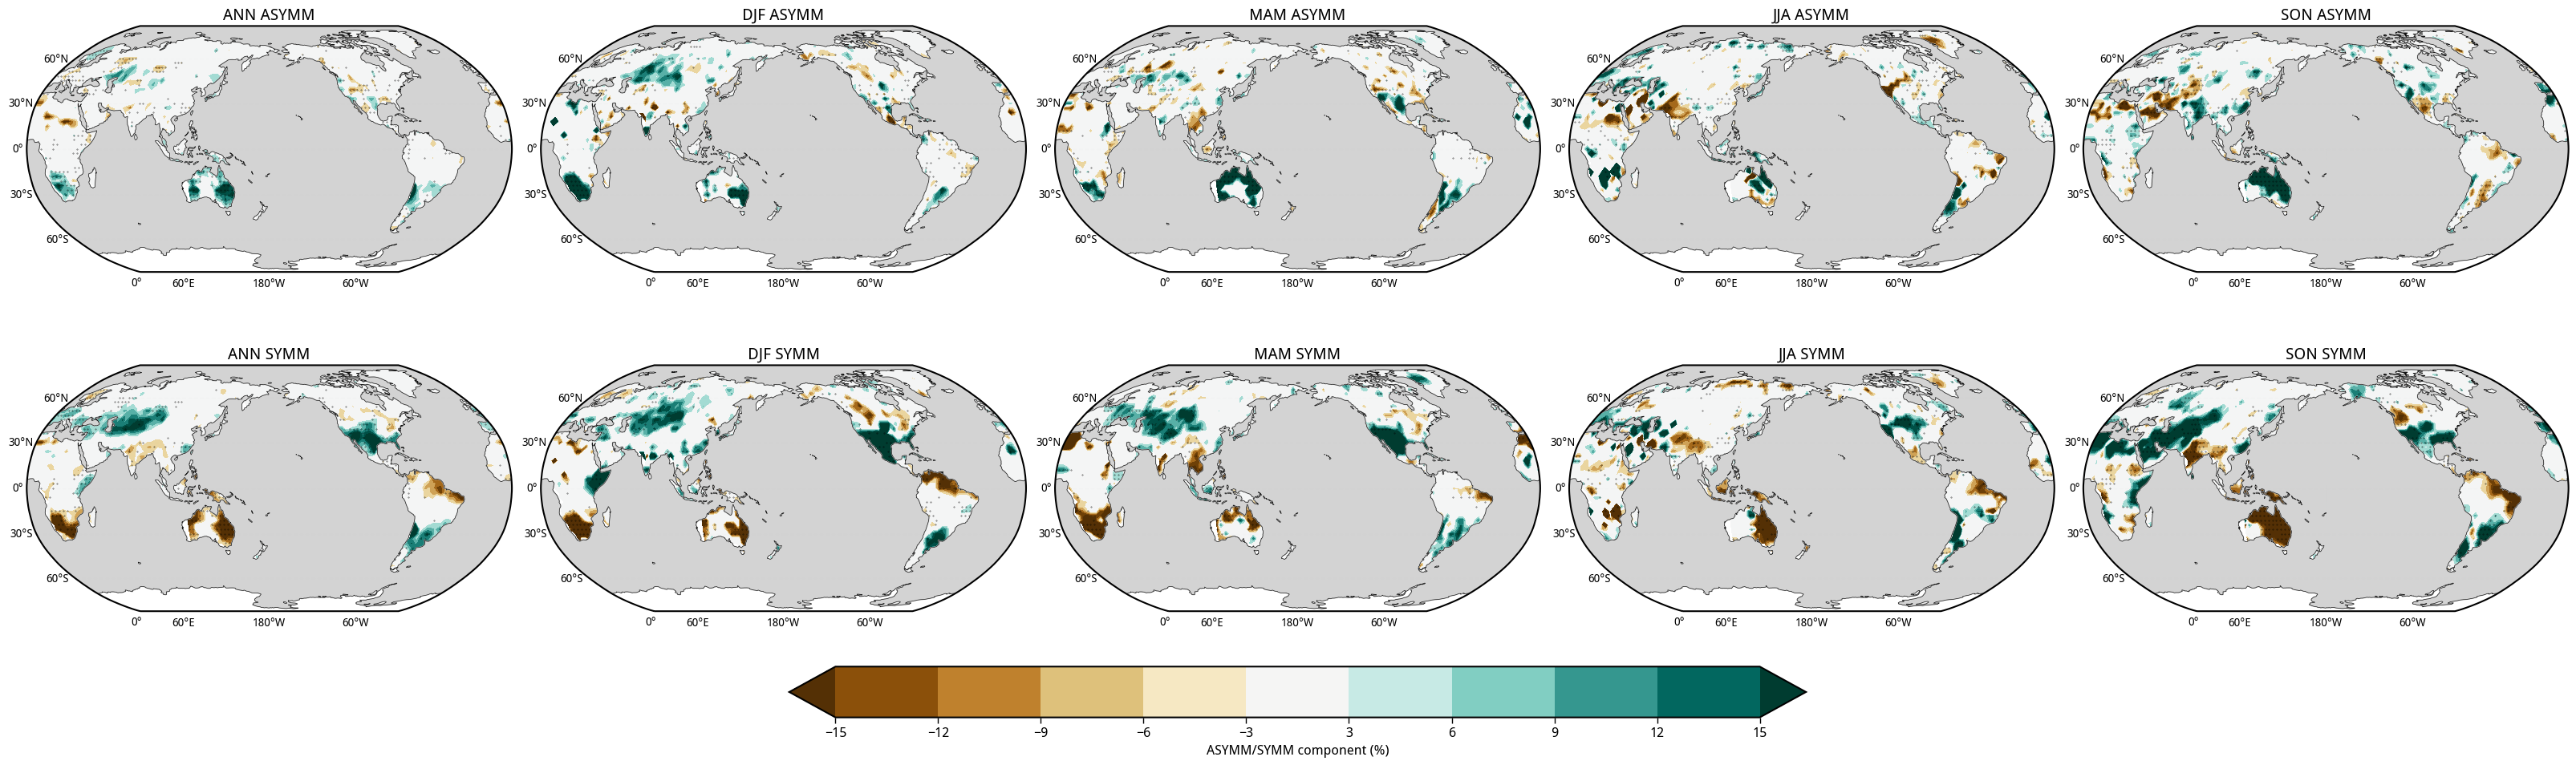

In [67]:
plot_kwargs = dict(cmap='BrBG', levels = [-15, -12, -9, -6, -3, 3, 6, 9, 12, 15], \
                   extend='both', cbar_label = 'ASYMM/SYMM component (%)', pval1=[], pval2=pval_list, \
                   sign_val=-1, nrows=2, ncols=5, figsize=(32,10), ocean_mask_list = np.arange(0,15,1), central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot(x, y, index_list_pc, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/obs_asymm_pc.png', dpi=300, bbox_inches='tight')

In [68]:
plot_list = [res_ann['nonl_pc']*100, res_djf['nonl_pc']*100, res_mam['nonl_pc']*100, res_jja['nonl_pc']*100, res_son['nonl_pc']*100,
             res_ann['lin_pc']*100, res_djf['lin_pc']*100, res_mam['lin_pc']*100, res_jja['lin_pc']*100, res_son['lin_pc']*100]

In [69]:
plot_list, xx = fix_gap_lon(plot_list, np.arange(-178.5, 184.5, 3))

In [70]:
titles_list = ['ANN ASYMM', 'DJF ASYMM', 'MAM ASYMM', 'JJA ASYMM', 'SON ASYMM',
               'ANN SYMM', 'DJF SYMM', 'MAM SYMM', 'JJA SYMM', 'SON SYMM']

In [71]:
pval_list = [res_ann['nature'], res_djf['nature'], res_mam['nature'], res_jja['nature'], res_son['nature'],
             res_ann['nature'], res_djf['nature'], res_mam['nature'], res_jja['nature'], res_son['nature']]

In [72]:
pval_list, xx = fix_gap_lon(pval_list, np.arange(-178.5, 184.5, 3))

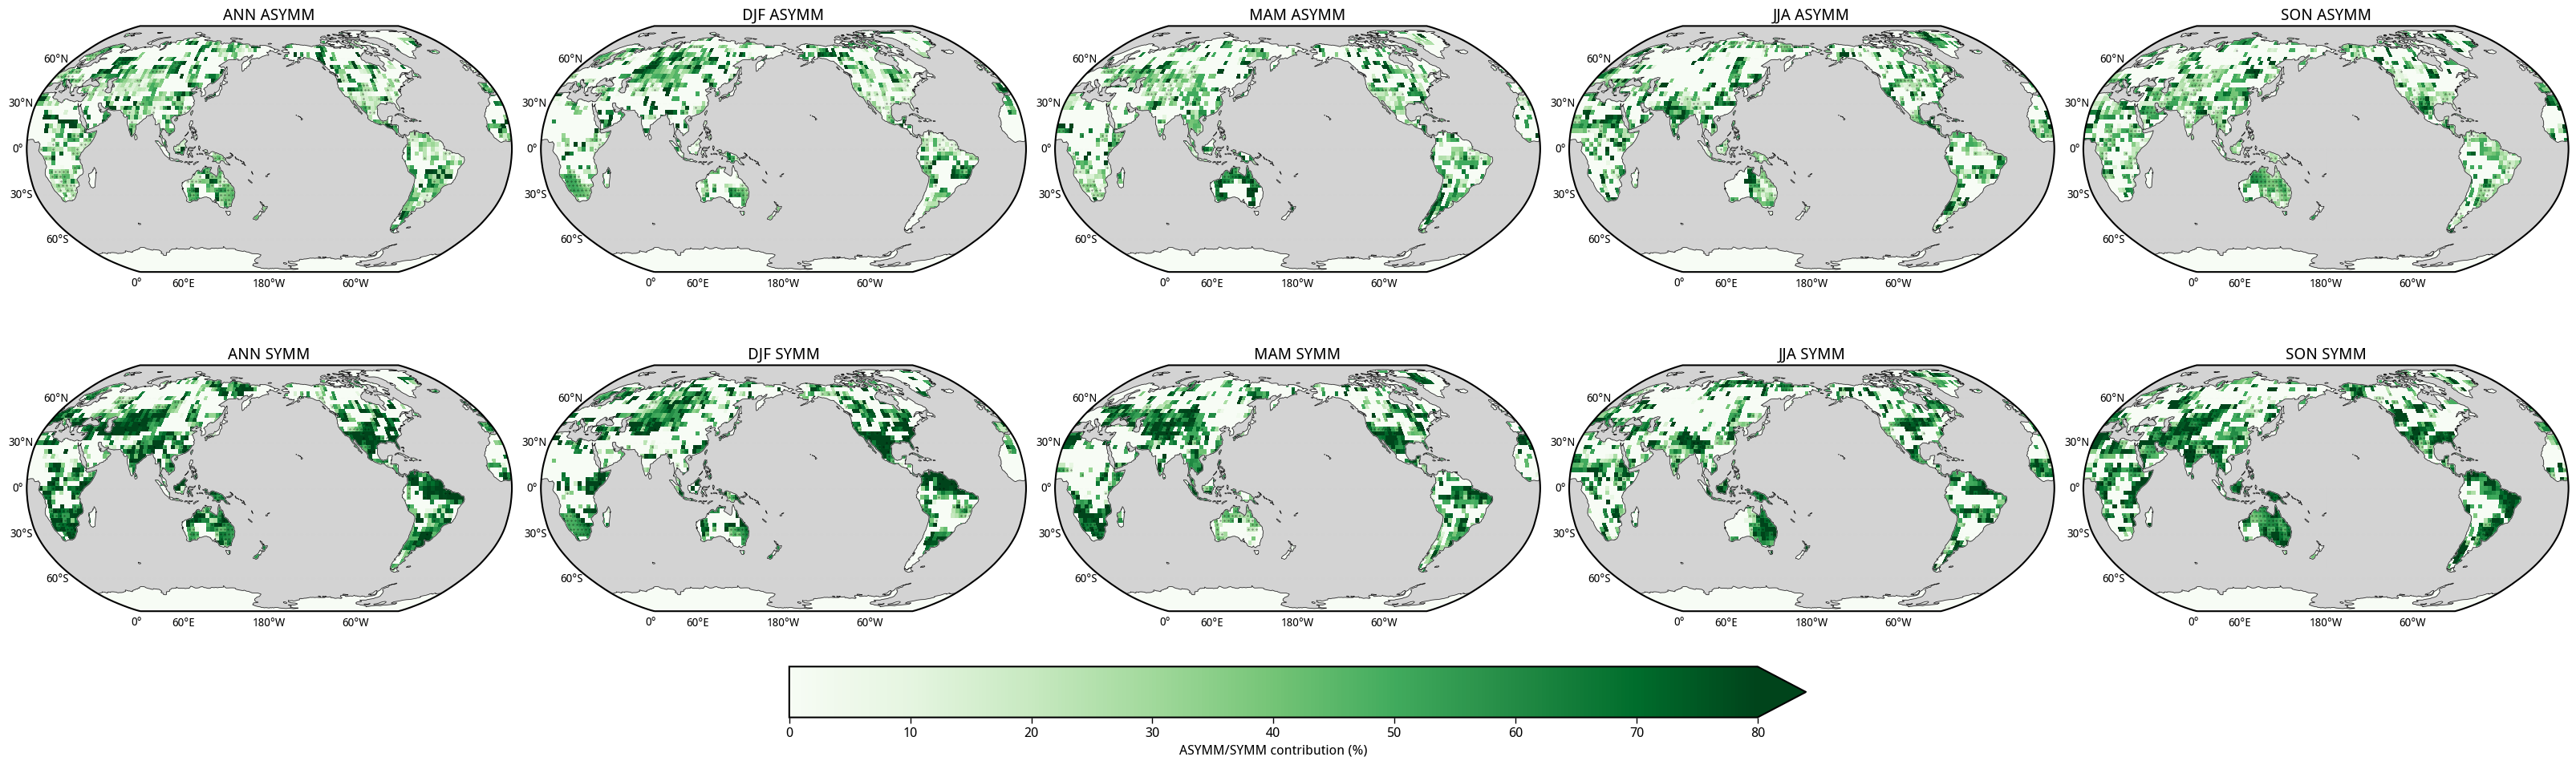

In [73]:
plot_kwargs = dict(cmap='Greens', vmin=0, vmax=80, \
                   extend='max', cbar_label = 'ASYMM/SYMM contribution (%)', pval1=[], pval2=pval_list, \
                   sign_val=-1, nrows=2, ncols=5, figsize=(32,10), ocean_mask_list = np.arange(0, 15, 1), central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot_mesh(x, y, plot_list, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/obs_asymm_contrib_land_only.png', dpi=300, bbox_inches='tight')

In [75]:
plot_list = [res_ann['ratio'], res_djf['ratio'], res_mam['ratio'], res_jja['ratio'], res_son['ratio']]

In [76]:
plot_list, xx = fix_gap_lon(plot_list, np.arange(-178.5, 184.5, 3))

In [77]:
titles_list = ['ANN', 'DJF', 'MAM', 'JJA', 'SON']

In [78]:
pval_list = [res_ann['nature'], res_djf['nature'], res_mam['nature'], res_jja['nature'], res_son['nature']]

In [79]:
pval_list, xx = fix_gap_lon(pval_list, np.arange(-178.5, 184.5, 3))

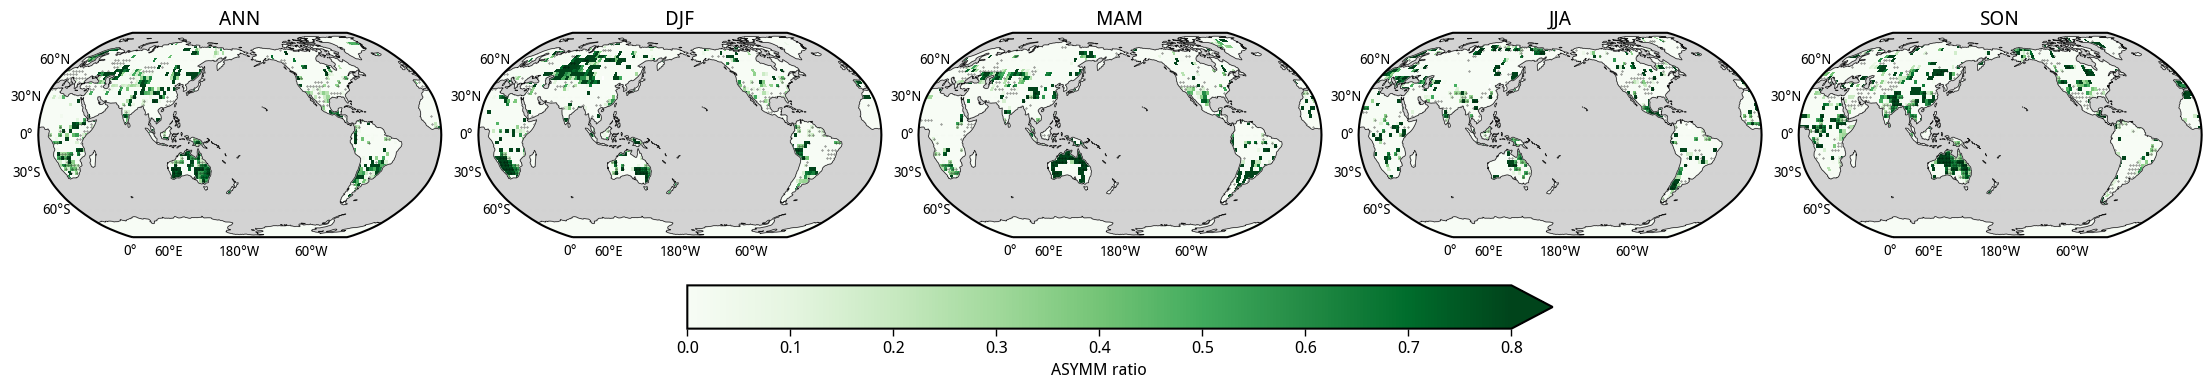

In [80]:
plot_kwargs = dict(cmap='Greens', vmin=0, vmax=0.8, \
                   extend='max', cbar_label = 'ASYMM ratio', pval1=[], pval2=pval_list, \
                   sign_val=-1, nrows=1, ncols=5, figsize=(22,6), ocean_mask_list = np.arange(0, 15, 1), central_longitude=180)

x, y = np.meshgrid(xx, precip.lat)
plot_mesh(x, y, plot_list, titles_list, **plot_kwargs)
plt.savefig('./PhD/prelim_tasks/images/obs_asymm_ratio_land_only.png', dpi=300, bbox_inches='tight')

In [97]:
import os

In [154]:
def save_files(res, season):
    save_loc = '/scratch/ob22/as8561/data/proc/rean/'
    os.system(f'mkdir -p {save_loc}{season}')
    for key in res.keys():
        np.save(save_loc + season + '/' + key, res[key])

In [155]:
save_files(res_ann, 'ann')
save_files(res_djf, 'djf')
save_files(res_mam, 'mam')
save_files(res_jja, 'jja')
save_files(res_son, 'son')

In [518]:
# model_djf = extract_composites(precip_anom_resid, nino_anom_resid, (precip.pr*86400*30), season_str='djf', threshold=threshold, min_duration=6, rolling_period=5)
# model_mam = extract_composites(precip_anom_resid, nino_anom_resid, (precip.pr*86400*30), season_str='mam', threshold=threshold, min_duration=6, rolling_period=5)
# model_jja = extract_composites(precip_anom_resid, nino_anom_resid, (precip.pr*86400*30), season_str='jja', threshold=threshold, min_duration=6, rolling_period=5)
# model_son = extract_composites(precip_anom_resid, nino_anom_resid, (precip.pr*86400*30), season_str='son', threshold=threshold, min_duration=6, rolling_period=5)

In [164]:
# import os

In [165]:
# def save_files(mod_name):
#     base_loc = '/scratch/ob22/as8561/data/results/'
#     os.system('mkdir -p ' + base_loc + mod_name)
#     os.system('mkdir -p ' + base_loc + mod_name + '/ann')
#     os.system('mkdir -p ' + base_loc + mod_name + '/djf')
#     os.system('mkdir -p ' + base_loc + mod_name + '/mam')
#     os.system('mkdir -p ' + base_loc + mod_name + '/jja')
#     os.system('mkdir -p ' + base_loc + mod_name + '/son')
#     for i in range(len(model_ann.keys())):
#         np.save(base_loc + f'{mod_name}/ann/{list(model_ann.keys())[i]}', list(model_ann.values())[i])
#         np.save(base_loc + f'{mod_name}/djf/{list(model_djf.keys())[i]}', list(model_djf.values())[i])
#         np.save(base_loc + f'{mod_name}/mam/{list(model_mam.keys())[i]}', list(model_mam.values())[i])
#         np.save(base_loc + f'{mod_name}/jja/{list(model_jja.keys())[i]}', list(model_jja.values())[i])
#         np.save(base_loc + f'{mod_name}/son/{list(model_son.keys())[i]}', list(model_son.values())[i])
#         print(f'Completed {i+1}/13')
#     print('Completed all')

In [166]:
# save_files(mod_name)

### Average analysis

In [45]:
def extract_scatters(detrended_var, nino_anom, base_var, season_str=None, threshold=0.8, min_duration=6, rolling_period=5):
    weights = np.cos(np.deg2rad(detrended_var.lat))
    weights.name = 'weights'
    detrended_var = detrended_var.weighted(weights).mean(('lat', 'lon'))
    base_var = base_var.weighted(weights).mean(('lat', 'lon'))
    if season_str==None: # for the annual period
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # get the corr
        xxxx = nino_anom.groupby('time.year').mean('time')
        yyyy = detrended_var.groupby('time.year').mean('time')
        corr = get_corr_1d(xxxx, yyyy)
        pval = get_pval_1d(xxxx, yyyy)
        # get std
        yy_std = detrended_var.groupby('time.year').mean('time').std('year')
        xx_std = nino_anom.groupby('time.year').mean('time').std('year')
        clim = base_var.mean('month')
        # get the nino_event_months
        ninoy = detrended_var[nino_idx].groupby('time.year').mean('time')#/yy_std
        ninay = detrended_var[nina_idx].groupby('time.year').mean('time')#/yy_std
        neuty = detrended_var[neut_idx].groupby('time.year').mean('time')#/yy_std
        ninox = nino_anom[nino_idx].groupby('time.year').mean('time')#/xx_std
        ninax = nino_anom[nina_idx].groupby('time.year').mean('time')#/xx_std
        neutx = nino_anom[neut_idx].groupby('time.year').mean('time')#/xx_std
        enc = ninoy.median('year') - neuty.median('year')
        lnc = ninay.median('year') - neuty.median('year')
        nonl = (enc+lnc)/2
        linear = (enc - lnc)/2
        return {
            'ninoy': ninoy,
            'ninox': ninox,
            'ninay': ninay,
            'ninax': ninax,
            'neuty': neuty,
            'neutx': neutx,
            'xx_std': xx_std,
            'yy_std': yy_std,
            'clim': clim,
            'corr': corr,
            'pval': pval,
            'enc': enc,
            'lnc': lnc,
            'nonl': nonl,
            'linear': linear
        }
    else:
        seasons_dict = {'djf':[12,1,2], 'mam':[3,4,5], 'jja':[6,7,8], 'son':[9,10,11], 'sondjf':[9,10,11,12,1,2]}
        # extract the indices
        nino_idx, nina_idx, neut_idx = get_event_indices(nino_anom, threshold, min_duration, rolling_period)
        # define the season arr
        season_month_arr = seasons_dict[season_str]
        # get the season for the individual cases
        season = nino_anom.time.dt.month.isin(season_month_arr)
        nino_season = nino_anom[nino_idx].time.dt.month.isin(season_month_arr)
        nina_season = nino_anom[nina_idx].time.dt.month.isin(season_month_arr)
        neut_season = nino_anom[neut_idx].time.dt.month.isin(season_month_arr)
        # get std
        yy_std = detrended_var.sel(time = season).groupby('time.year').mean('time').std('year')
        xx_std = nino_anom.sel(time = season).groupby('time.year').mean('time').std('year')
        # clim
        clim = base_var.sel(month = season_month_arr).mean('month')
        # get the corr
        xxxx = nino_anom.sel(time = season).groupby('time.year').mean('time')
        yyyy = detrended_var.sel(time = season).groupby('time.year').mean('time')
        corr = get_corr_1d(xxxx, yyyy)
        pval = get_pval_1d(xxxx, yyyy)
        # get the nino_event_months
        neuty = detrended_var[neut_idx].sel(time=neut_season).groupby('time.year').mean('time')#/yy_std
        ninoy = detrended_var[nino_idx].sel(time=nino_season).groupby('time.year').mean('time')#/yy_std
        ninay = detrended_var[nina_idx].sel(time=nina_season).groupby('time.year').mean('time')#/yy_std
        neutx = nino_anom[neut_idx].sel(time=neut_season).groupby('time.year').mean('time')#/xx_std
        ninox = nino_anom[nino_idx].sel(time=nino_season).groupby('time.year').mean('time')#/xx_std
        ninax = nino_anom[nina_idx].sel(time=nina_season).groupby('time.year').mean('time')#/xx_std
        enc = ninoy.median('year') - neuty.median('year')
        lnc = ninay.median('year') - neuty.median('year')
        nonl = (enc+lnc)/2
        linear = (enc - lnc)/2
        return {
            'ninoy': ninoy,
            'ninox': ninox,
            'ninay': ninay,
            'ninax': ninax,
            'neuty': neuty,
            'neutx': neutx,
            'xx_std': xx_std,
            'yy_std': yy_std,
            'clim': clim,
            'corr': corr,
            'pval': pval,
            'enc': enc,
            'lnc': lnc,
            'nonl': nonl,
            'linear': linear
        }

In [46]:
import regionmask

In [100]:
mask = regionmask.defined_regions.ar6.land.mask_3D(precip, wrap_lon=False, drop=False)
mask_land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask_3D(precip, wrap_lon=False, drop=False)

In [122]:
# res_ann = extract_scatters(precip.where(mask.isel(region = -7)), nino, precip_base.where(mask.isel(region=-7)))
# res_djf = extract_scatters(precip.where(mask.isel(region = -7)), nino, precip_base.where(mask.isel(region=-7)), season_str='djf')
# res_mam = extract_scatters(precip.where(mask.isel(region = -7)), nino, precip_base.where(mask.isel(region=-7)), season_str='mam')
res_jja = extract_scatters(reorder(precip.where(mask_land.isel(region=0)).where(mask.isel(region = -7))), reorder(nino), precip_base.where(mask_land.isel(region=0)).where(mask.isel(region=-7)), season_str='jja')
# res_son = extract_scatters(precip.where(mask.isel(region = -7)), nino, precip_base.where(mask.isel(region=-7)), season_str='son')

In [534]:
res_sondjf = extract_scatters(precip.where(mask.isel(region = 225)), nino, season_str='sondjf')

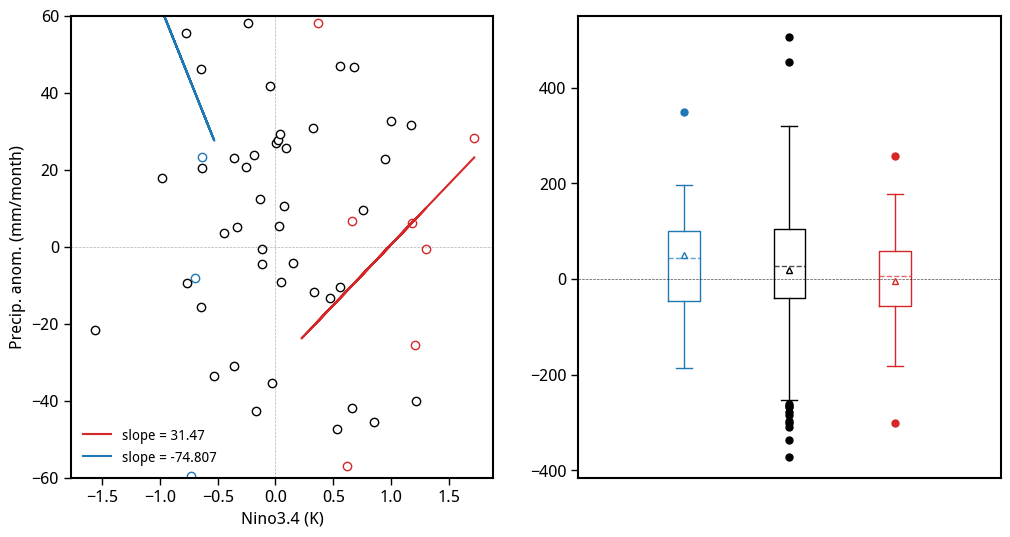

In [124]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(res_jja['ninox'], ((res_jja['ninoy']/res_jja['clim'])*100), color='tab:red', facecolor='white')
plt.scatter(res_jja['ninax'], ((res_jja['ninay']/res_jja['clim'])*100), color='tab:blue', facecolor='white')
plt.scatter(res_jja['neutx'], ((res_jja['neuty']/res_jja['clim'])*100), color='k', facecolor='white')
res_nino  = stats.linregress(res_jja['ninox'], ((res_jja['ninoy']/res_jja['clim'])*100))
res_nina  = stats.linregress(res_jja['ninax'], ((res_jja['ninay']/res_jja['clim'])*100))
plt.plot(res_jja['ninox'], res_jja['ninox']*res_nino.slope + res_nino.intercept, color='tab:red', label = f'slope = {np.round(res_nino.slope, 3)}')
plt.plot(res_jja['ninax'], res_jja['ninax']*res_nina.slope + res_nina.intercept, color='tab:blue', label = f'slope = {np.round(res_nina.slope, 3)}')
plt.axhline(0, alpha=0.3, color='k', ls='--', lw=0.5)
plt.axvline(0, alpha=0.3, color='k', ls='--', lw=0.5)
# plt.ylim(-2.5, 2.5)
plt.ylim(-60,60)
plt.legend(frameon=False, fontsize=10)
plt.ylabel('Precip. anom. (mm/month)')
plt.xlabel('Nino3.4 (K)')

plt.subplot(122)
plt.boxplot([((res_jja['ninay']/res_jja['clim'])*100)], positions=[0.5], **kwargs_ln)
plt.boxplot([((res_jja['ninoy']/res_jja['clim'])*100)], positions=[1.5], **kwargs_en)
plt.boxplot([((res_jja['neuty']/res_jja['clim'])*100)], positions=[1.0], **kwargs_neut)
plt.xticks([])
plt.axhline(0, lw=0.5, alpha=0.7, color='k', ls='--')
plt.axvline(0, lw=0.5, alpha=0.7, color='k', ls='--')
# plt.savefig('./PhD/prelim_tasks/images/pres/scatter_box.png', dpi=300, bbox_inches='tight')

In [110]:
res_jja['clim']

<xarray.DataArray 'precip' (region: 1)>
array([4.46832081])
Coordinates:
  * region   (region) int64 0

In [128]:
res_jja['ninoy'].median()

<xarray.DataArray 'precip' ()>
array(0.27237948)

In [552]:
res_sondjf['pval']

0.00019769253285112143

Text(0.5, 1.0, 'SON')

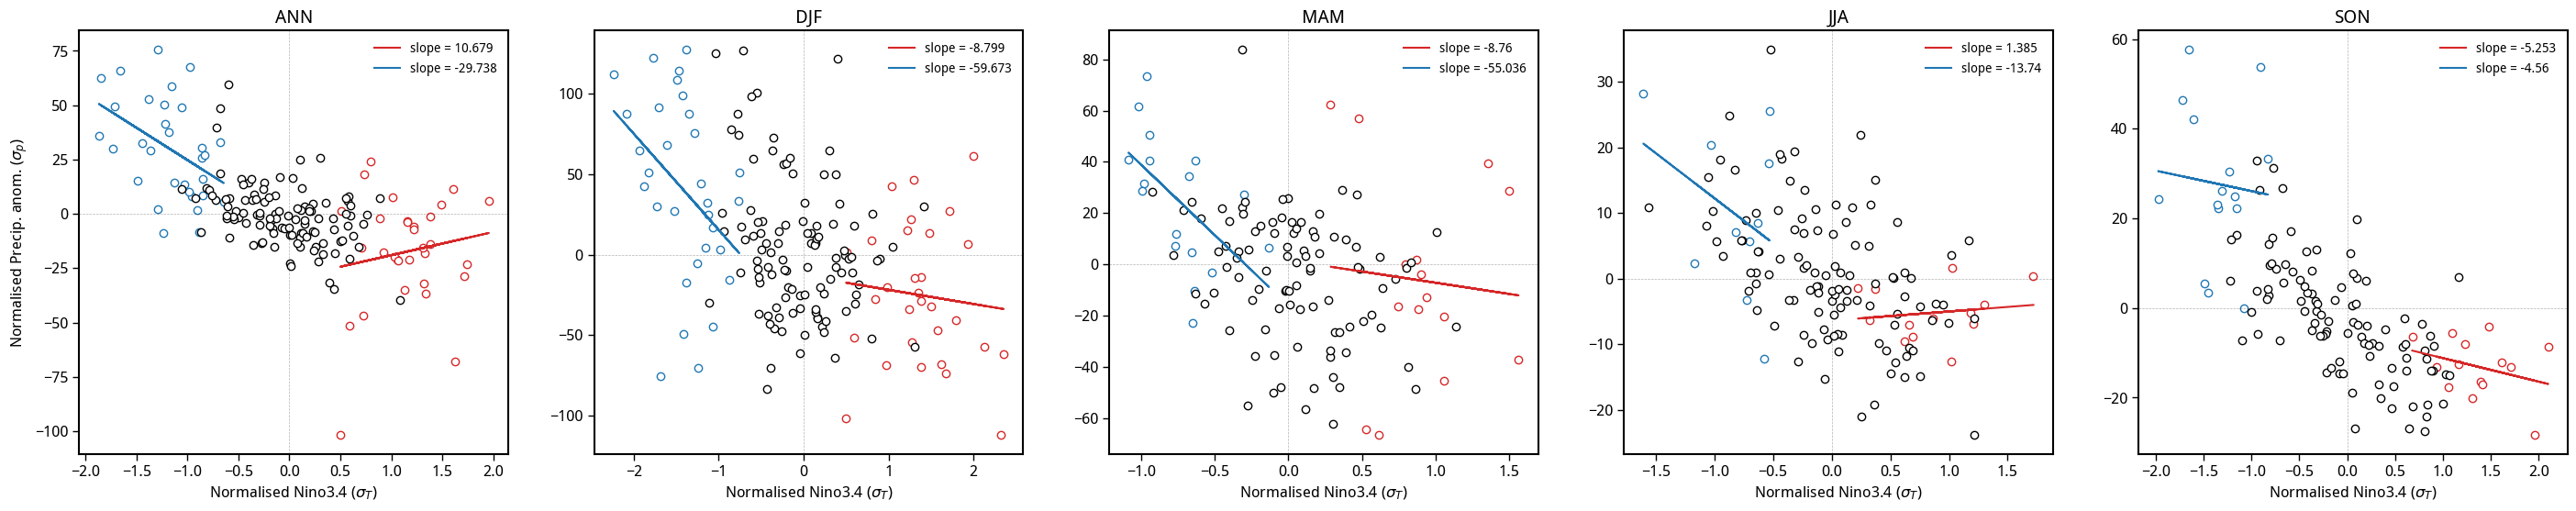

In [25]:
fig = plt.figure(figsize=(35,6))

plt.subplot(151)
plt.scatter(res_ann['ninox'], res_ann['ninoy'], color='tab:red', facecolor='white')
plt.scatter(res_ann['ninax'], res_ann['ninay'], color='tab:blue', facecolor='white')
plt.scatter(res_ann['neutx'], res_ann['neuty'], color='k', facecolor='white')
res_nino  = stats.linregress(res_ann['ninox'], res_ann['ninoy'])
res_nina  = stats.linregress(res_ann['ninax'], res_ann['ninay'])
plt.plot(res_ann['ninox'], res_ann['ninox']*res_nino.slope + res_nino.intercept, color='tab:red', label = f'slope = {np.round(res_nino.slope, 3)}')
plt.plot(res_ann['ninax'], res_ann['ninax']*res_nina.slope + res_nina.intercept, color='tab:blue', label = f'slope = {np.round(res_nina.slope, 3)}')
plt.axhline(0, alpha=0.3, color='k', ls='--', lw=0.5)
plt.axvline(0, alpha=0.3, color='k', ls='--', lw=0.5)
# plt.ylim(-2.5, 2.5)
plt.legend(frameon=False, fontsize=10)
plt.ylabel('Normalised Precip. anom. ($\sigma_{p}$)')
plt.xlabel('Normalised Nino3.4 ($\sigma_{T}$)')
plt.title('ANN')

plt.subplot(152)
plt.scatter(res_djf['ninox'], res_djf['ninoy'], color='tab:red', facecolor='white')
plt.scatter(res_djf['ninax'], res_djf['ninay'], color='tab:blue', facecolor='white')
plt.scatter(res_djf['neutx'], res_djf['neuty'], color='k', facecolor='white')
res_nino  = stats.linregress(res_djf['ninox'], res_djf['ninoy'])
res_nina  = stats.linregress(res_djf['ninax'], res_djf['ninay'])
plt.plot(res_djf['ninox'], res_djf['ninox']*res_nino.slope + res_nino.intercept, color='tab:red', label = f'slope = {np.round(res_nino.slope, 3)}')
plt.plot(res_djf['ninax'], res_djf['ninax']*res_nina.slope + res_nina.intercept, color='tab:blue', label = f'slope = {np.round(res_nina.slope, 3)}')
plt.axhline(0, alpha=0.3, color='k', ls='--', lw=0.5)
plt.axvline(0, alpha=0.3, color='k', ls='--', lw=0.5)
# plt.ylim(-2.5, 2.5)
plt.xlabel('Normalised Nino3.4 ($\sigma_{T}$)')
plt.legend(frameon=False, fontsize=10)
plt.title('DJF')

plt.subplot(153)
plt.scatter(res_mam['ninox'], res_mam['ninoy'], color='tab:red', facecolor='white')
plt.scatter(res_mam['ninax'], res_mam['ninay'], color='tab:blue', facecolor='white')
plt.scatter(res_mam['neutx'], res_mam['neuty'], color='k', facecolor='white')
res_nino  = stats.linregress(res_mam['ninox'], res_mam['ninoy'])
res_nina  = stats.linregress(res_mam['ninax'], res_mam['ninay'])
plt.plot(res_mam['ninox'], res_mam['ninox']*res_nino.slope + res_nino.intercept, color='tab:red', label = f'slope = {np.round(res_nino.slope, 3)}')
plt.plot(res_mam['ninax'], res_mam['ninax']*res_nina.slope + res_nina.intercept, color='tab:blue', label = f'slope = {np.round(res_nina.slope, 3)}')
plt.axhline(0, alpha=0.3, color='k', ls='--', lw=0.5)
plt.axvline(0, alpha=0.3, color='k', ls='--', lw=0.5)
# plt.ylim(-2.5, 2.5)
plt.xlabel('Normalised Nino3.4 ($\sigma_{T}$)')
plt.legend(frameon=False, fontsize=10)
plt.title('MAM')

plt.subplot(154)
plt.scatter(res_jja['ninox'], res_jja['ninoy'], color='tab:red', facecolor='white')
plt.scatter(res_jja['ninax'], res_jja['ninay'], color='tab:blue', facecolor='white')
plt.scatter(res_jja['neutx'], res_jja['neuty'], color='k', facecolor='white')
res_nino  = stats.linregress(res_jja['ninox'], res_jja['ninoy'])
res_nina  = stats.linregress(res_jja['ninax'], res_jja['ninay'])
plt.plot(res_jja['ninox'], res_jja['ninox']*res_nino.slope + res_nino.intercept, color='tab:red', label = f'slope = {np.round(res_nino.slope, 3)}')
plt.plot(res_jja['ninax'], res_jja['ninax']*res_nina.slope + res_nina.intercept, color='tab:blue', label = f'slope = {np.round(res_nina.slope, 3)}')
plt.axhline(0, alpha=0.3, color='k', ls='--', lw=0.5)
plt.axvline(0, alpha=0.3, color='k', ls='--', lw=0.5)
# plt.ylim(-2.5, 2.5)
plt.xlabel('Normalised Nino3.4 ($\sigma_{T}$)')
plt.legend(frameon=False, fontsize=10)
plt.title('JJA')

plt.subplot(155)
plt.scatter(res_son['ninox'], res_son['ninoy'], color='tab:red', facecolor='white')
plt.scatter(res_son['ninax'], res_son['ninay'], color='tab:blue', facecolor='white')
plt.scatter(res_son['neutx'], res_son['neuty'], color='k', facecolor='white')
res_nino  = stats.linregress(res_son['ninox'], res_son['ninoy'])
res_nina  = stats.linregress(res_son['ninax'], res_son['ninay'])
plt.plot(res_son['ninox'], res_son['ninox']*res_nino.slope + res_nino.intercept, color='tab:red', label = f'slope = {np.round(res_nino.slope, 3)}')
plt.plot(res_son['ninax'], res_son['ninax']*res_nina.slope + res_nina.intercept, color='tab:blue', label = f'slope = {np.round(res_nina.slope, 3)}')
plt.axhline(0, alpha=0.3, color='k', ls='--', lw=0.5)
plt.axvline(0, alpha=0.3, color='k', ls='--', lw=0.5)
# plt.ylim(-2.5, 2.5)
plt.xlabel('Normalised Nino3.4 ($\sigma_{T}$)')
plt.legend(frameon=False, fontsize=10)
plt.title('SON')

# plt.savefig('./PhD/prelim_tasks/images/nonl_mean_aus.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Normalised precip anom (as fraction of $\\sigma_p$)')

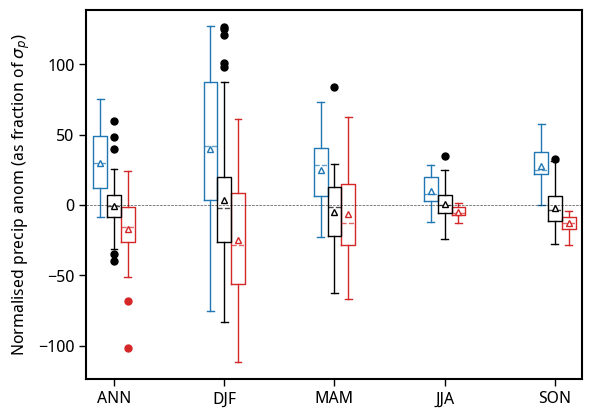

In [26]:
meanpointprops = dict(marker='^', markeredgecolor='k',
                      markerfacecolor='white', markersize=5)
meanpointprops_en = dict(marker='^', markeredgecolor='tab:red',
                      markerfacecolor='white', markersize=5)
meanpointprops_ln = dict(marker='^', markeredgecolor='tab:blue',
                      markerfacecolor='white', markersize=5)

boxprops = dict(linestyle='-', linewidth=1, color='k')
boxprops_en = dict(linestyle='-', linewidth=1, color='tab:red')
boxprops_ln = dict(linestyle='-', linewidth=1, color='tab:blue')

flierprops = dict(marker='o', markerfacecolor='k', markersize=5,
                  markeredgecolor='k')
flierprops_en = dict(marker='o', markerfacecolor='tab:red', markersize=5,
                  markeredgecolor='tab:red')
flierprops_ln = dict(marker='o', markerfacecolor='tab:blue', markersize=5,
                  markeredgecolor='tab:blue')

medianprops = dict(linestyle='--', linewidth=1, color='k', alpha=0.7)
medianprops_en = dict(linestyle='--', linewidth=1, color='tab:red', alpha=0.7)
medianprops_ln = dict(linestyle='--', linewidth=1, color='tab:blue', alpha=0.7)

whiskerprops_en = dict(color='tab:red')
whiskerprops_ln = dict(color='tab:blue')
capprops_en = dict(color='tab:red')
capprops_ln = dict(color='tab:blue')


kwargs_ln = dict(showmeans=True, meanprops = meanpointprops_ln, boxprops=boxprops_ln, flierprops=flierprops_ln, medianprops=medianprops_ln, capprops=capprops_ln, whiskerprops=whiskerprops_ln)
kwargs_en = dict(showmeans=True, meanprops = meanpointprops_en, boxprops=boxprops_en, flierprops=flierprops_en, medianprops=medianprops_en, capprops=capprops_en, whiskerprops=whiskerprops_en)
kwargs_neut = dict(showmeans=True, meanprops = meanpointprops, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops)
plt.boxplot([res_ann['ninay'], res_djf['ninay'], res_mam['ninay'], res_jja['ninay'], res_son['ninay']], positions=[0,4,8,12,16], **kwargs_ln)
plt.boxplot([res_ann['ninoy'], res_djf['ninoy'], res_mam['ninoy'], res_jja['ninoy'], res_son['ninoy']], positions=[1,5,9,13,17], **kwargs_en)
plt.boxplot([res_ann['neuty'], res_djf['neuty'], res_mam['neuty'], res_jja['neuty'], res_son['neuty']], positions=[0.5, 4.5, 8.5, 12.5, 16.5], **kwargs_neut)
plt.xticks([0.5, 4.5, 8.5, 12.5, 16.5], labels=['ANN', 'DJF', 'MAM', 'JJA', 'SON'])
plt.axhline(0, lw=0.5, alpha=0.7, color='k', ls='--')
plt.ylabel('Normalised precip anom (as fraction of $\sigma_p$)')

# plt.savefig('./PhD/prelim_tasks/images/nonl_mean_box_aus.png', dpi=300, bbox_inches='tight')

In [440]:
res_mam['corr'], res_mam['pval']

(-0.2755306557247692, 0.002878980170507073)

In [437]:
import seaborn as sns
import pandas as pd

Text(0.5, 0, '')

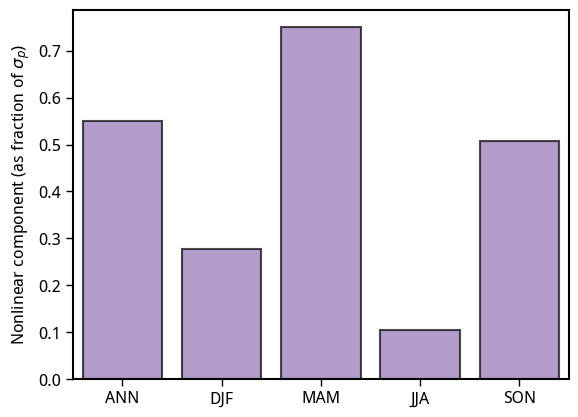

In [438]:
xxx = ['ANN', 'DJF', 'MAM', 'JJA', 'SON']
yyy = np.array([float(res_ann['nonl']), float(res_djf['nonl']), float(res_mam['nonl']), float(res_jja['nonl']), float(res_son['nonl'])])
lll = np.array([float(res_ann['lnc']), float(res_djf['lnc']), float(res_mam['lnc']), float(res_jja['lnc']), float(res_son['lnc'])])
eee = np.array([float(res_ann['enc']), float(res_djf['enc']), float(res_mam['enc']), float(res_jja['enc']), float(res_son['enc'])])
sss = np.array([float(res_ann['yy_std']), float(res_djf['yy_std']), float(res_mam['yy_std']), float(res_jja['yy_std']), float(res_son['yy_std'])])
df = pd.DataFrame(dict(season=xxx, nonl=(yyy)))

sns.barplot(data=df,x='season',y='nonl', color='tab:purple', linewidth=1.5, edgecolor='k', alpha=0.7)
plt.ylabel('Nonlinear component (as fraction of $\sigma_p$)')
plt.xlabel('')
# plt.savefig('./PhD/prelim_tasks/images/glob_nonl.png', dpi=300, bbox_inches='tight')

In [425]:
df_obs = df
df_obs

season      nonl
0    ANN  0.675306
1    DJF  0.267705
2    MAM  0.740307
3    JJA  0.104930
4    SON  0.422413

In [439]:
df_rean = df
df_rean

season      nonl
0    ANN  0.549611
1    DJF  0.276824
2    MAM  0.749975
3    JJA  0.103978
4    SON  0.507376

In [107]:
import regionmask

In [108]:
mask = regionmask.defined_regions.ar6.land.mask_3D(precip, wrap_lon=False)

In [142]:
mask.region

<xarray.DataArray 'region' (region: 46)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45])
Coordinates:
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
    abbrevs  (region) <U4 'GIC' 'NWN' 'NEN' 'WNA' ... 'SAU' 'NZ' 'EAN' 'WAN'
    names    (region) <U22 'Greenland/Iceland' ... 'W.Antarctica'

In [147]:
out_arr = []
nature = []
hatches = []
for i in range(46):
    test = extract_scatters(precip.where(mask.isel(region=i)), nino, season_str=None)
    enc = float(test['ninoy'].mean('year') - test['neuty'].mean('year'))
    lnc = float(test['ninay'].mean('year') - test['neuty'].mean('year'))
    if float(enc) > float(lnc):
        nature.append('nino')
        hatches.append('//')
    else:
        nature.append('nina')
        hatches.append('')
    out = (enc+lnc)/2
    out_arr.append(out)
    print(f'completed {i+1}/46', end='\r')

In [148]:
df = regionmask.defined_regions.ar6.land.to_dataframe()

In [149]:
df['nonl'] = out_arr
df['nature'] = nature
df['hatches'] = hatches

In [150]:
df.head()

abbrevs              names      nonl nature hatches
numbers                                                    
0           GIC  Greenland/Iceland  0.097678   nina        
1           NWN  N.W.North-America -0.330815   nino      //
2           NEN  N.E.North-America -0.214708   nina        
3           WNA    W.North-America -0.013641   nina        
4           CNA    C.North-America -0.095708   nino      //

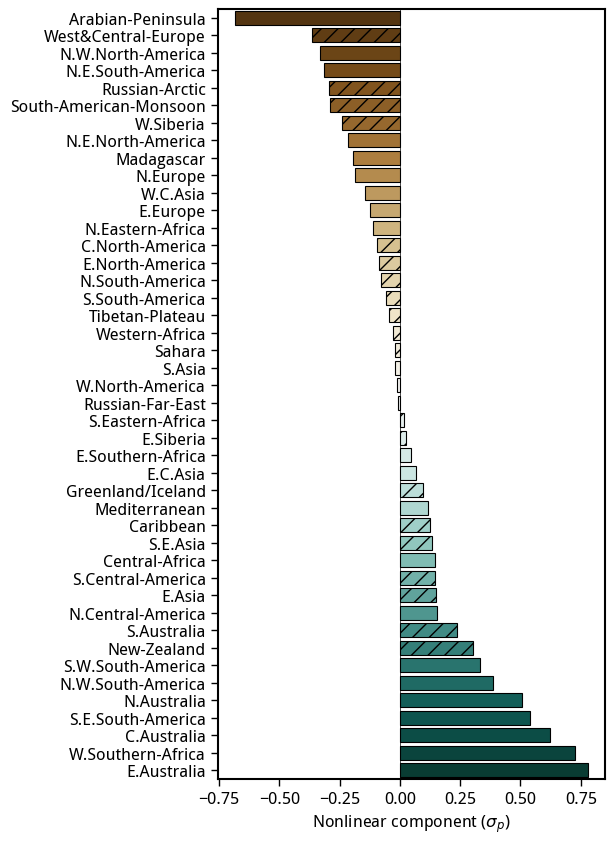

In [154]:
plt.figure(figsize=(5,10))
ax = sns.barplot(data=df.sort_values('nonl')[:-2], x='nonl', y ='names', palette='BrBG', linewidth=0.8, edgecolor='k')
for i,thisbar in enumerate(ax.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(df['hatches'][i])
plt.axvline(0, color='k', lw=0.5)
plt.ylabel('')
plt.xlabel('Nonlinear component ($\sigma_{p}$)')
plt.savefig('./PhD/prelim_tasks/images/nonl_ann_ar6.png', dpi=300, bbox_inches='tight')